In [1]:
import glob
import os
import shutil
import h5py
import pickle
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import coregister, invert_ebb
from lameg.simulate import run_current_density_simulation
from lameg.laminar import model_comparison
from lameg.util import get_surface_names, load_meg_sensor_data
from lameg.viz import show_surface
import spm_standalone

In [8]:
snr_levels=[-50,-35,-20,-10,-5,0,5]

In [3]:
nas = [-12.4, 86.4, -35.4]
lpa = [-49.4, 5.0, -41.7]
rpa = [51.8, 13.6, -41.7]

data_file = '/home/bonaiuto/laminar_baby/data/derivatives/P001_T1/Pspm_p001_t1_run01_epo.mat'

spm = spm_standalone.initialize()

In [4]:
mri_fname='/home/bonaiuto/laminar_baby/data/derivatives/217/6m/T1.nii'
multilayer_mesh_fname='/home/bonaiuto/laminar_baby/data/derivatives/217/6m/multilayer.11.ds.link_vector.fixed.gii'

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Get name of each mesh that makes up the layers of the multilayer mesh - these will be used for the source 
# reconstruction
layer_fnames = get_surface_names(
    n_layers, 
    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m', 
    'link_vector.fixed'
)

In [5]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/baby'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

In [6]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    fid_labels=['Nasion','LPA','RPA'],
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
26-Jul-2024 15:15:22 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 15:15:22 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           15:15:22 - 26/07/2024
multilayer.11.ds.link_vector.fixed
creating layout from cfg.grad
creating layout for neuromag306 system

SPM: spm_eeg_inv_forward                           15:16:27 -

26-Jul-2024 15:24:00 - Done    'Source inversion, iterative'
26-Jul-2024 15:24:00 - Done



In [7]:
data_fname=os.path.join(tmp_dir, 'SPMgainmatrix_Pspm_p001_t1_run01_epo_1.mat')
with h5py.File(data_fname, 'r') as file:
    G=file['G'][()]
    
n_layers=11
n_verts=G.shape[0]
verts_per_surf=int(n_verts/n_layers)

pial_G=G[:verts_per_surf,:]
white_G=G[(n_layers-1)*verts_per_surf:,]

rms=np.sqrt(np.sum((pial_G-white_G)**2,-1))

sim_vertex=np.argmax(rms)
print(sim_vertex)

29008


Text(0, 0.5, 'Amplitude (nAm)')

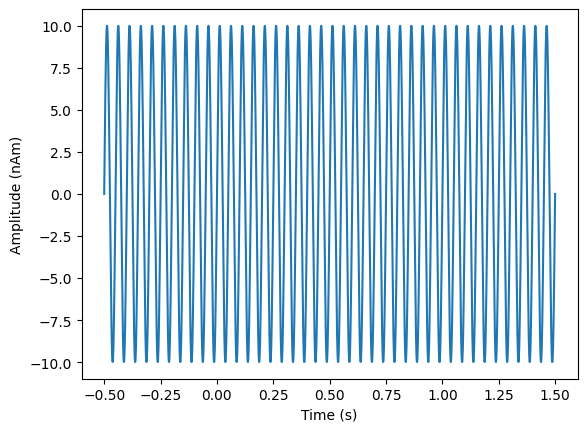

In [8]:
# Frequency of simulated sinusoid (Hz)
freq = 20
# Strength of simulated activity (nAm)
dipole_moment = 10
# Sampling rate (must match the data file)
s_rate = 2000

# Generate 1s of a sine wave at a sampling rate of 600Hz (to match the data file)
time = np.linspace(-.5,1.5,s_rate+1)
sim_signal = np.sin(time*freq*2*np.pi).reshape(1,-1)

plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

In [9]:
pial_ds_mesh_fname = '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii'
pial_ds_mesh = nib.load(pial_ds_mesh_fname)
pial_coord = pial_ds_mesh.darrays[0].data[sim_vertex,:]
pial_mesh_fname = '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.gii'
pial_mesh = nib.load(pial_mesh_fname)
cam_view = [152, 28, 15,
            3.5, 26, 38.5,
            0, 0, 1]
plot = show_surface(
    pial_mesh, 
    opacity=1, 
    coords=pial_coord,
    coord_size=2,
    camera_view=cam_view
)

Output()

In [10]:
# Size of simulated patch of activity (mm)
sim_patch_size = 5

In [11]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run model comparison across
# all layers
snr_layerF = []
for snr in snr_levels:
    all_layerF = []

    for l in range(n_layers):
        print(f'Simulating in layer {l}')
        l_vertex = l*verts_per_surf+sim_vertex
        prefix = f'sim_{sim_vertex}_{l}_'

        l_sim_fname = run_current_density_simulation(
            base_fname, 
            prefix, 
            l_vertex, 
            sim_signal, 
            dipole_moment, 
            sim_patch_size, 
            snr,
            spm_instance=spm
        ) 

        [layerF,_] = model_comparison(
            nas, 
            lpa, 
            rpa, 
            mri_fname, 
            layer_fnames, 
            l_sim_fname, 
            viz=False,
            spm_instance=spm,
            coregister_kwargs={
                'fid_labels': ['Nasion','LPA','RPA']
            },
            invert_kwargs={
                'patch_size': patch_size, 
                'n_temp_modes': n_temp_modes        
            }
        )
        all_layerF.append(layerF)
    all_layerF = np.array(all_layerF)
    snr_layerF.append(all_layerF)
snr_layerF=np.array(snr_layerF)

Simulating in layer 0
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix:  - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_0_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 526.76 pAm/mm2, peak momemnt density 1280.64 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 526.76, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1280.64, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_0_Pspm_p001_t1_run01_epo/prior503793.mat
Setting white noise to give sensor level SNR of -50B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) U

Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.060147e+03 [+4.12]
  ReML Iteration 2                      :        ...6.910947e+02 [+4.25]
  ReML Iteration 3                      :        ...4.009391e+02 [+4.38]
  ReML Iteration 4                      :        ...1.8

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 15:30:37 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 15:30:37 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      15:32:26 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:34:36 - 26/07/2024
Completed                               :          15:34:36 - 26/07/2024
26-Jul-2024 15:34:37 - Done    'Head model specification'
26-Jul-2024 15:34:37 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      15:34:37 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

26-Jul-2024 15:36:16 - Done    'Source inversion, iterative'
26-Jul-2024 15:36:16 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 15:36:18 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 15:36:18 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:36:44 - 26/07/2024
Completed                               :          15:36:44 - 26/07/2024
26-Jul-2024

Percent variance explained 2.78 (0.02)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 15:38:36 - Done    'Source inversion, iterative'
26-Jul-2024 15:38:36 - Done

Simulating in layer 1
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_1_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 577.90 pAm/mm2, peak momemnt density 1369.32 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment densit



------------------------------------------------------------------------
26-Jul-2024 15:42:29 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 15:42:29 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 15:44:16 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 15:44:16 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          15:46:06 - 26/07/2024
26-Jul-2024 15:46:06 - Done    'Head model specification'
26-Jul-2024 15:46:06 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      15:46:07 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
26-Jul-2024 15:47:48 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 15:47:48 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:48:19 - 26/07/2024
Completed                               :          15:48:19 - 26/07/2024
26-Jul-2024 15:48:20 - Done    'Head model specification'
26-Jul-2024 15:48:20 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 2.04 (0.01)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 15:49:55 - Done    'Source inversion, iterative'
26-Jul-2024 15:49:55 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 15:49:59 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 15:49:59 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:50:24 - 26/

Percent variance explained 2.04 (0.01)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 15:52:02 - Done    'Source inversion, iterative'
26-Jul-2024 15:52:02 - Done

Simulating in layer 2
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_2_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 542.21 pAm/mm2, peak momemnt density 1389.12 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment densit

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.097230e+03 [+4.12]
  ReML Iteration 2                      :        ...7.137709e+02 [+4.25]
  ReML Iteration 3                      :        ...3.987242e+02 [+4.38]
  ReML Iteration 4     



------------------------------------------------------------------------
26-Jul-2024 15:58:08 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 15:58:08 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov



------------------------------------------------------------------------
26-Jul-2024 16:00:01 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:00:01 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov



------------------------------------------------------------------------
26-Jul-2024 16:02:03 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:02:03 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov



------------------------------------------------------------------------
26-Jul-2024 16:04:14 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:04:14 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:08:29 - 26/07/2024
Completed                               :          16:08:29 - 26/07/2024
26-Jul-2024 16:08:30 - Done    'Head model specification'
26-Jul-2024 16:08:30 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:08:30 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simul

26-Jul-2024 16:10:06 - Done    'Source inversion, iterative'
26-Jul-2024 16:10:06 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 16:10:07 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:10:07 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:10:29 - 26/07/2024
Completed                               :          16:10:29 - 26/07/2024
26-Jul-2024

  ReML Iteration 2                      :        ...6.723733e+02 [+4.25]
  ReML Iteration 3                      :        ...3.797729e+02 [+4.38]
  ReML Iteration 4                      :        ...1.726284e+02 [+4.50]
  ReML Iteration 5                      :        ...5.680683e+01 [+4.62]
  ReML Iteration 6                      :        ...3.444519e-03 [+4.75]
Percent variance explained 1.29 (0.01)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 16:12:10 - Done    'Source inversion, iterative'
26-Jul-2024 16:12:10 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modif

 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.047395e+03 [+4.12]
  ReML Iteration 2                      :        ...6.712448e+02 [+4.25]
  ReML Iteration 3                      :        ...3.795133e+02 [+4.38]
  ReML Iteration 4                      :        ...1.727152e+02 [+4.50]
  ReML Iteration 5                      :        ...5.689874e+01 [+4.62]
  ReML Iteration 6                      :        ...3.379156e-03 [+4.75]
Inverting subject 1
  ReML Iteration 1                      :        ...1.047395e+03 [+4.12]
  ReML Iteration 2                      :        ...6.712448e+02 [+4.25]
  ReML Iteration 3                      :        ...3.795133e+02 [+4.38]
  ReML Iteration 4          



------------------------------------------------------------------------
26-Jul-2024 16:16:19 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:16:19 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 16:18:18 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:18:18 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Setting white noise to give sensor level SNR of -50B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 16:22:07 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:22:07 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:22:37 - 26/07/2024
Completed                               :          16:22:38 - 26/07/20

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.036936e+03 [+4.12]
  ReML Iteration 2                      :        ...6.648341e+02 [+4.25]
  ReML Iteration 3                      :        ...3.813663e+02 [+4.38]
  ReML Iteration 4                      :        ...1.746202e+02 [+4.50]
  ReML Iteration 5                      :        ...5.496335e+01 [+4.62]
  ReML Iteration 6                      :        ...1.980537e-02 [+4.75]
  ReML Iteration 7                      :        ...6.421785e-09 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.036936e+03 [+4.12]
  ReML Iteration 2                      :        ...6.648341e+02 [+4.25]
  ReML Iteration 3                      :        ...3.813663e+02 [+4.38]
  ReML Iteration 4                      :        ...1.746202e+02 [+4.50]
  ReML Iteration 5                      :        ...5.496335e+01 [+4.62]
  ReML Iteration 6                      :        ...1.980537e-02 

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 16:25:42 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:25:42 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:27:36 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
26-Jul-2024 16:29:10 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:29:10 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:29:28 - 26/07/2024
Completed                               :          16:29:28 - 26/07/2024
26-Jul-2024 16:29:29 - Done    'Head model specification'
26-Jul-2024 16:29:29 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 1.49 (0.01)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 16:31:11 - Done    'Source inversion, iterative'
26-Jul-2024 16:31:11 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 16:31:12 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:31:12 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:31:37 - 26/

NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.025899e+03 [+4.12]
  ReML Iteration 2                      :        ...6.598673e+02 [+4.25]
  ReML Iteration 3                      :        ...3.803910e+02 [+4.38]
  ReML Iteration 4                      :        ...1.751448e+02 [+4.50]
  ReML Iteration 5                      :        ...5.541246e+01 [+4.62]
  ReML Iteration 6                      :        ...1.865156e-02 [+4.75]
  ReML Iteration 7                      :        ...5.704904e-09 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.025899e+03 [+4.12]
  ReML Iteration 2                      :        ...6.598673e+02 [+4.25]
  ReML Iteration 3                      :        ...3.803910e+02 [+4.38]
  ReML Iteration 4                      :        ...1.751448e+02 [+4.50]
  ReML Iteration 5                      :        ...5.541246e+01 [+4.62]
  ReML Iteration 6                     

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:36:53 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:38:45 - 26/07/2024
Completed                               :          16:38:46 - 26/07/2024
26-Jul-2024 16:38:46 - Done    'Head model specification'
26-Jul-2024 16:38:46 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:38:47 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

26-Jul-2024 16:40:20 - Done    'Source inversion, iterative'
26-Jul-2024 16:40:20 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 16:40:22 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:40:22 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:40:47 - 26/07/2024
Completed                               :          16:40:48 - 26/07/2024
26-Jul-2024

Percent variance explained 3.02 (0.02)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 16:42:28 - Done    'Source inversion, iterative'
26-Jul-2024 16:42:28 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 16:42:29 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:42:29 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:42:52 - 26/

Percent variance explained 3.02 (0.02)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 16:44:41 - Done    'Source inversion, iterative'
26-Jul-2024 16:44:41 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 16:44:42 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:44:42 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:45:03 - 26/

Percent variance explained 3.01 (0.02)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 16:46:44 - Done    'Source inversion, iterative'
26-Jul-2024 16:46:45 - Done

Simulating in layer 6
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_6_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 561.13 pAm/mm2, peak momemnt density 1648.79 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment densit



------------------------------------------------------------------------
26-Jul-2024 16:50:51 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:50:51 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:52:37 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
26-Jul-2024 16:54:18 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:54:18 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:54:43 - 26/07/2024
Completed                               :          16:54:43 - 26/07/2024
26-Jul-2024 16:54:44 - Done    'Head model specification'
26-Jul-2024 16:54:44 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 1.47 (0.01)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 16:56:22 - Done    'Source inversion, iterative'
26-Jul-2024 16:56:22 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 16:56:25 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:56:25 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:56:46 - 26/

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.043714e+03 [+4.12]
  ReML Iteration 2                      :        ...6.722968e+02 [+4.25]
  ReML Iteration 3                      :        ...3.790313e+02 [+4.38]
  ReML Iteration 4                      :        ...1.672238e+02 [+4.50]
  ReML Iteration 5                      :        ...5.051668e+01 [+4.62]
  ReML Iteration 6                      :        ...5.793328e-02 [+4.75]
  ReML Iteration 7                      :        ...5.367404e-08 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.043714e+03 [+4.12]
  ReML Iteration 2                      :        ...6.722968e+02 [+4.25]
  ReML Iteration 3                      :        ...3.790313e+02 [+4.38]
  ReML Iteration 4                      :        ...1.672238e+02 [+4.50]
  ReML Iteration 5                      :        ...5.051668e+01 [+4.62]
  ReML Iteration 6                      :        ...5.793328e-02 



------------------------------------------------------------------------
26-Jul-2024 16:59:56 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 16:59:56 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov



------------------------------------------------------------------------
26-Jul-2024 17:03:38 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:03:38 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:04:04 - 26/07/2024
Completed                               :          17:04:05 - 26/07/2024
26-Jul-2024 17:04:06 - Done    'Head model specification'
26-Jul-2024 17:04:06 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 0.58 (0.00)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:05:35 - Done    'Source inversion, iterative'
26-Jul-2024 17:05:35 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:05:36 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:05:36 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:06:01 - 26/

Percent variance explained 0.58 (0.00)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:07:45 - Done    'Source inversion, iterative'
26-Jul-2024 17:07:45 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:07:46 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:07:47 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:08:09 - 26/

Percent variance explained 0.58 (0.00)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:09:46 - Done    'Source inversion, iterative'
26-Jul-2024 17:09:46 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:09:48 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:09:48 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:10:12 - 26/

Percent variance explained 0.57 (0.00)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:11:51 - Done    'Source inversion, iterative'
26-Jul-2024 17:11:51 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:11:53 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:11:53 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:12:10 - 26/

Percent variance explained 0.57 (0.00)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:13:42 - Done    'Source inversion, iterative'
26-Jul-2024 17:13:42 - Done

Simulating in layer 8
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_8_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 532.56 pAm/mm2, peak momemnt density 1592.88 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment densit



------------------------------------------------------------------------
26-Jul-2024 17:17:47 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:17:47 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:19:29 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
26-Jul-2024 17:21:13 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:21:13 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:21:39 - 26/07/2024
Completed                               :          17:21:39 - 26/07/2024
26-Jul-2024 17:21:40 - Done    'Head model specification'
26-Jul-2024 17:21:40 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 1.01 (0.01)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:23:09 - Done    'Source inversion, iterative'
26-Jul-2024 17:23:09 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:23:11 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:23:11 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:23:36 - 26/

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.051180e+03 [+4.12]
  ReML Iteration 2                      :        ...6.762952e+02 [+4.25]
  ReML Iteration 3                      :        ...3.819395e+02 [+4.38]
  ReML Iteration 4                      :        ...1.673710e+02 [+4.50]
  ReML Iteration 5                      :        ...4.901431e+01 [+4.62]
  ReML Iteration 6                      :        ...4.863160e-02 [+4.75]
  ReML Iteration 7                      :        ...3.793979e-08 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.051180e+03 [+4.12]
  ReML Iteration 2                      :        ...6.762952e+02 [+4.25]
  ReML Iteration 3                      :        ...3.819395e+02 [+4.38]
  ReML Iteration 4                      :        ...1.673710e+02 [+4.50]
  ReML Iteration 5                      :        ...4.901431e+01 [+4.62]
  ReML Iteration 6                      :        ...4.863160e-02 



------------------------------------------------------------------------
26-Jul-2024 17:26:56 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:26:56 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov



------------------------------------------------------------------------
26-Jul-2024 17:30:47 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:30:47 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:31:12 - 26/07/2024
Completed                               :          17:31:12 - 26/07/2024
26-Jul-2024 17:31:13 - Done    'Head model specification'
26-Jul-2024 17:31:13 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

26-Jul-2024 17:32:43 - Done    'Source inversion, iterative'
26-Jul-2024 17:32:43 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:32:44 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:32:44 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:33:03 - 26/07/2024
Completed                               :          17:33:04 - 26/07/2024
26-Jul-2024

Percent variance explained 2.56 (0.02)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:34:46 - Done    'Source inversion, iterative'
26-Jul-2024 17:34:46 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:34:48 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:34:48 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:35:14 - 26/

Percent variance explained 2.56 (0.02)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:36:47 - Done    'Source inversion, iterative'
26-Jul-2024 17:36:47 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:36:49 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:36:49 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:37:15 - 26/

Percent variance explained 2.56 (0.02)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:38:54 - Done    'Source inversion, iterative'
26-Jul-2024 17:38:54 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:38:55 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:38:55 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:39:20 - 26/

Percent variance explained 2.56 (0.02)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:41:01 - Done    'Source inversion, iterative'
26-Jul-2024 17:41:01 - Done

Simulating in layer 10
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_10_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 527.48 pAm/mm2, peak momemnt density 1547.08 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.066868e+03 [+4.12]
  ReML Iteration 2                      :        ...6.886739e+02 [+4.25]
  ReML Iteration 3                      :        ...3.922750e+02 [+4.38]
  ReML Iteration 4    



------------------------------------------------------------------------
26-Jul-2024 17:46:36 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:46:36 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
26-Jul-2024 17:48:03 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:48:03 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 0.71 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:49:24 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:49:24 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed nu


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:50:45 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:50:45 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:53:50 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:53:50 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:54:14 - 26/07/2024
Completed                               :          17:54:15 - 26/07/2024
26-Jul-2024 17:54:15 - Done    'Head model specification'
26-Jul-2024 17:54:15 - Done

Smoothing /home

Percent variance explained 99.39 (3.73)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:55:32 - Done    'Source inversion, iterative'
26-Jul-2024 17:55:32 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:55:33 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:55:33 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:55:53 - 26

Percent variance explained 99.37 (3.73)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:57:10 - Done    'Source inversion, iterative'
26-Jul-2024 17:57:10 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:57:11 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:57:11 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:57:31 - 26

Percent variance explained 99.33 (3.73)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 17:58:59 - Done    'Source inversion, iterative'
26-Jul-2024 17:59:00 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 17:59:01 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 17:59:01 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:59:25 - 26

Percent variance explained 99.32 (3.73)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 18:01:02 - Done    'Source inversion, iterative'
26-Jul-2024 18:01:02 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:01:03 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:01:03 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:01:17 - 26

Percent variance explained 99.31 (3.73)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 18:02:36 - Done    'Source inversion, iterative'
26-Jul-2024 18:02:36 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:02:37 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:02:37 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:02:57 - 26



------------------------------------------------------------------------
26-Jul-2024 18:06:08 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:06:08 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 3.76 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provi


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:08:14 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:08:14 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          18:09:50 - 26/07/2024
26-Jul-2024 18:09:50 - Done    'Head model specification'
26-Jul-2024 18:09:50 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      18:09:51 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
26-Jul-2024 18:11:23 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:11:23 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:11:53 - 26/07/2024
Completed                               :          18:11:54 - 26/07/2024
26-Jul-2024 18:11:55 - Done    'Head model specification'
26-Jul-2024 18:11:55 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.30 (3.73)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 18:13:37 - Done    'Source inversion, iterative'
26-Jul-2024 18:13:37 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:13:38 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:13:38 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:13:53 - 26

Percent variance explained 99.31 (3.73)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 18:15:00 - Done    'Source inversion, iterative'
26-Jul-2024 18:15:00 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:15:03 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:15:03 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:15:18 - 26



------------------------------------------------------------------------
26-Jul-2024 18:18:10 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:18:10 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 3.73 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provi


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:19:52 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:19:52 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          18:21:15 - 26/07/2024
26-Jul-2024 18:21:16 - Done    'Head model specification'
26-Jul-2024 18:21:16 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      18:21:16 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
26-Jul-2024 18:22:21 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:22:21 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:22:36 - 26/07/2024
Completed                               :          18:22:36 - 26/07/2024
26-Jul-2024 18:22:36 - Done    'Head model specification'
26-Jul-2024 18:22:36 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.31 (3.70)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 18:23:52 - Done    'Source inversion, iterative'
26-Jul-2024 18:23:52 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:23:54 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:23:54 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:24:13 - 26

Percent variance explained 99.33 (3.70)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 18:25:34 - Done    'Source inversion, iterative'
26-Jul-2024 18:25:34 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:25:35 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:25:35 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:25:50 - 26



------------------------------------------------------------------------
26-Jul-2024 18:28:47 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:28:47 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 3.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provi


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:30:13 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:30:13 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          18:31:30 - 26/07/2024
26-Jul-2024 18:31:30 - Done    'Head model specification'
26-Jul-2024 18:31:30 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      18:31:31 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
26-Jul-2024 18:33:07 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:33:07 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:33:33 - 26/07/2024
Completed                               :          18:33:33 - 26/07/2024
26-Jul-2024 18:33:34 - Done    'Head model specification'
26-Jul-2024 18:33:34 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.37 (3.72)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 18:35:21 - Done    'Source inversion, iterative'
26-Jul-2024 18:35:21 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:35:23 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:35:23 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:35:47 - 26

Percent variance explained 99.39 (3.72)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 18:37:21 - Done    'Source inversion, iterative'
26-Jul-2024 18:37:21 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:37:23 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:37:23 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:37:47 - 26



------------------------------------------------------------------------
26-Jul-2024 18:41:12 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:41:12 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 3.76 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provi


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:43:12 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:43:12 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          18:45:08 - 26/07/2024
26-Jul-2024 18:45:08 - Done    'Head model specification'
26-Jul-2024 18:45:08 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      18:45:09 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
26-Jul-2024 18:46:49 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:46:49 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:47:14 - 26/07/2024
Completed                               :          18:47:14 - 26/07/2024
26-Jul-2024 18:47:14 - Done    'Head model specification'
26-Jul-2024 18:47:14 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.34 (3.73)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 18:48:38 - Done    'Source inversion, iterative'
26-Jul-2024 18:48:38 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:48:40 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:48:40 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:49:04 - 26

Percent variance explained 99.34 (3.73)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 18:50:37 - Done    'Source inversion, iterative'
26-Jul-2024 18:50:37 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:50:40 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:50:40 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:50:59 - 26



------------------------------------------------------------------------
26-Jul-2024 18:54:37 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:54:37 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 3.76 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provi


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 18:56:47 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:56:47 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          18:58:23 - 26/07/2024
26-Jul-2024 18:58:24 - Done    'Head model specification'
26-Jul-2024 18:58:24 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      18:58:24 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
26-Jul-2024 18:59:51 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 18:59:51 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:00:10 - 26/07/2024
Completed                               :          19:00:11 - 26/07/2024
26-Jul-2024 19:00:11 - Done    'Head model specification'
26-Jul-2024 19:00:11 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.34 (3.74)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 19:01:48 - Done    'Source inversion, iterative'
26-Jul-2024 19:01:48 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:01:50 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:01:50 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:02:09 - 26

Percent variance explained 99.30 (3.74)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 19:03:45 - Done    'Source inversion, iterative'
26-Jul-2024 19:03:45 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:03:47 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:03:47 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:04:12 - 26



------------------------------------------------------------------------
26-Jul-2024 19:07:45 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:07:45 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 3.80 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provi


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:09:32 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:09:32 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          19:11:28 - 26/07/2024
26-Jul-2024 19:11:29 - Done    'Head model specification'
26-Jul-2024 19:11:29 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      19:11:29 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
26-Jul-2024 19:13:10 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:13:10 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:13:35 - 26/07/2024
Completed                               :          19:13:35 - 26/07/2024
26-Jul-2024 19:13:36 - Done    'Head model specification'
26-Jul-2024 19:13:36 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.45 (3.78)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 19:15:28 - Done    'Source inversion, iterative'
26-Jul-2024 19:15:28 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:15:30 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:15:30 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:15:55 - 26

Percent variance explained 99.38 (3.78)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 19:17:29 - Done    'Source inversion, iterative'
26-Jul-2024 19:17:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:17:31 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:17:31 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:17:57 - 26



------------------------------------------------------------------------
26-Jul-2024 19:21:33 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:21:33 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 3.78 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provi


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:23:25 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:23:25 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          19:25:16 - 26/07/2024
26-Jul-2024 19:25:17 - Done    'Head model specification'
26-Jul-2024 19:25:17 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      19:25:18 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
26-Jul-2024 19:26:52 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:26:52 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:27:11 - 26/07/2024
Completed                               :          19:27:11 - 26/07/2024
26-Jul-2024 19:27:11 - Done    'Head model specification'
26-Jul-2024 19:27:11 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.38 (3.75)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 19:28:51 - Done    'Source inversion, iterative'
26-Jul-2024 19:28:51 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:28:52 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:28:52 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:29:14 - 26

Percent variance explained 99.30 (3.75)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 19:30:47 - Done    'Source inversion, iterative'
26-Jul-2024 19:30:47 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:30:49 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:30:49 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:31:08 - 26



------------------------------------------------------------------------
26-Jul-2024 19:34:45 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:34:45 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 3.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provi


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:36:59 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:36:59 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          19:38:50 - 26/07/2024
26-Jul-2024 19:38:50 - Done    'Head model specification'
26-Jul-2024 19:38:50 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      19:38:51 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
26-Jul-2024 19:40:23 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:40:23 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:40:42 - 26/07/2024
Completed                               :          19:40:42 - 26/07/2024
26-Jul-2024 19:40:43 - Done    'Head model specification'
26-Jul-2024 19:40:43 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.44 (3.81)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 19:42:29 - Done    'Source inversion, iterative'
26-Jul-2024 19:42:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:42:31 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:42:32 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:42:54 - 26

Percent variance explained 99.41 (3.81)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 19:44:24 - Done    'Source inversion, iterative'
26-Jul-2024 19:44:24 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:44:28 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:44:28 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:44:46 - 26



------------------------------------------------------------------------
26-Jul-2024 19:48:20 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:48:20 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 3.82 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provi


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:50:24 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:50:24 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          19:52:20 - 26/07/2024
26-Jul-2024 19:52:21 - Done    'Head model specification'
26-Jul-2024 19:52:21 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      19:52:21 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
26-Jul-2024 19:54:05 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:54:05 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:54:30 - 26/07/2024
Completed                               :          19:54:30 - 26/07/2024
26-Jul-2024 19:54:31 - Done    'Head model specification'
26-Jul-2024 19:54:31 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.44 (3.80)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 19:56:20 - Done    'Source inversion, iterative'
26-Jul-2024 19:56:20 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:56:24 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:56:24 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:56:50 - 26

Percent variance explained 99.43 (3.80)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 19:58:20 - Done    'Source inversion, iterative'
26-Jul-2024 19:58:20 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 19:58:23 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 19:58:23 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:58:42 - 26



------------------------------------------------------------------------
26-Jul-2024 20:02:36 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:02:36 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 3.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:04:30 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:04:30 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname

Completed                               :          20:06:21 - 26/07/2024
26-Jul-2024 20:06:21 - Done    'Head model specification'
26-Jul-2024 20:06:21 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      20:06:22 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MA

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:07:52 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:07:52 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:08:13 - 26/07/2024
Completed                               :          20:08:13 - 26/07/2024
26-Jul-2024 20:08:14 - Done    'Head model specification'
26-Jul-2024 20:08:14 - Done

Smoothing /hom

Percent variance explained 99.47 (3.85)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 20:09:48 - Done    'Source inversion, iterative'
26-Jul-2024 20:09:48 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:09:50 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:09:50 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:10:16 - 26

Percent variance explained 99.46 (3.85)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 20:12:01 - Done    'Source inversion, iterative'
26-Jul-2024 20:12:02 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:12:03 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:12:03 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:12:29 - 26



------------------------------------------------------------------------
26-Jul-2024 20:16:05 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:16:05 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 24.94 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:17:48 - 26/07/2024
Completed                               :          20:17:49 - 26/07/2024
26-Jul-2024 20:17:49 - Done    'Head model specification'
26-Jul-2024 20:17:49 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      20:17:50 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.97 (24.93)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 20:19:03 - Done    'Source inversion, iterative'
26-Jul-2024 20:19:03 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:19:04 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:19:04 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:19:18 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 24.94 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.452924e+04 [+4.12]
  ReML Iteration 2                      :        ...1.321612e+04 [+4.25]
  ReML Iteration 3                      :        ...1.080444e+04 [+4.38]
  ReML Iteration 4                      :        ...6.710947e+03 [+4.50]
  ReML Iteration 5                      :        ...2.239579e+03 [+4.62]
  ReML Iteration 6                      :        ...1.678084e+02 [+4.75]
  ReML Iteration 7                      :        ...2.776775e+00 [+4.88]
  ReML Iteration 8                      :        ...1.576922e-01 [+5.00]
  ReML Iteration 9                      :        ...1.000009e-02 [+5.12]
  ReML Iteration 10                     :        ...6.503697e-04 [+5.25]
Inverting subject 1
  ReML Iteration 1                    

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      20:21:38 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

Percent variance explained 99.96 (24.93)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 20:22:42 - Done    'Source inversion, iterative'
26-Jul-2024 20:22:42 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:22:42 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:22:42 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:22:57 - 2

Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 24.94 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.449274e+04 [+4.12]
  ReML Iteration 2                      :        ...1.317449e+04 [+4.25]
  ReML Iteration 3                      :        ...1.074293e+04 [+4.38]
  ReML Iteration 4                      :        ...6.641963e+03 [+4.50]
  ReML Iteration 5                      :        ...2.204451e+03 [+4.62]
  ReML Iteration 6                      :        ...2.224292e+02 [+4.75]
  ReML Iteration 7                      :        ...4.094546e

26-Jul-2024 20:27:04 - Done    'Source inversion, iterative'
26-Jul-2024 20:27:04 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:27:06 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:27:06 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:27:24 - 26/07/2024
Completed                               :          20:27:25 - 26/07/2024
26-Jul-2024

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 24.91 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.497306e+04 [+4.12]
  ReML Iteration 2                      :        ...1.366581e+04 [+4.25]
  ReML Iteration 3                      :        ...1.123290e+04 [+4.38]
  ReML Iteration 4                      :        ...7.022869e+03 [+4.50]
  ReML Iteration 5                      :        ...2.347399e+03 [+4.62]
  ReML Iteration 6                      :        ...7.575869e+01 [+4.75]
  ReML Iteration 7                      :        ...1.382373e+00 [+4.88]
  ReML Iteration 8                      :        ...6.719019e-02 [+5.00]
  ReML Iteration 9                      :        ...3.605100e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.497306e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:29:42 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:29:42 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:31:03 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:31:03 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:31:21 - 26/07/2024
Completed                               :          20:31:21 - 26/07/2024
26-Jul-2024 20:31:21 - Done    'Head model specification'
26-Jul-2024 20:31:21 - Done

Smoothing /hom

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 24.91 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.452272e+04 [+4.12]
  ReML Iteration 2                      :        ...1.323046e+04 [+4.25]
  ReML Iteration 3                      :        ...1.081905e+04 [+4.38]
  ReML Iteration 4                      :        ...6.707919e+03 [+4.50]
  ReML Iteration 5                      :        ...2.223549e+03 [+4.62]
  ReML Iteration 6                      :        ...1.518303e+02 [+4.75]
  ReML Iteration 7                      :        ...2.522477e+00 [+4.88]
  ReML Iteration 8                      :        ...1.387521e-01 [+5.00]
  ReML Iteration 9                      :        ...8.507631e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.452272e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:33:43 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:33:43 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Percent variance explained 99.96 (24.90)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 20:34:54 - Done    'Source inversion, iterative'
26-Jul-2024 20:34:54 - Done

Simulating in layer 2
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_2_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 542.21 pAm/mm2, peak momemnt density 1389.12 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
26-Jul-2024 20:37:51 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:37:51 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 24.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:39:09 - 26/07/2024
Completed                               :          20:39:10 - 26/07/2024
26-Jul-2024 20:39:10 - Done    'Head model specification'
26-Jul-2024 20:39:10 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      20:39:10 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.97 (24.88)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 20:40:33 - Done    'Source inversion, iterative'
26-Jul-2024 20:40:33 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:40:34 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:40:34 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:40:49 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 24.89 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.441879e+04 [+4.12]
  ReML Iteration 2                      :        ...1.311855e+04 [+4.25]
  ReML Iteration 3                      :        ...1.071809e+04 [+4.38]
  ReML Iteration 4                      :        ...6.654924e+03 [+4.50]
  ReML Iteration 5                      :        ...2.222599e+03 [+4.62]
  ReML Iteration 6                      :        ...1.657166e+02 [+4.75]
  ReML Iteration 7                      :        ...2.265099e+00 [+4.88]
  ReML Iteration 8                      :        ...1.144437e-01 [+5.00]
  ReML Iteration 9                      :        ...6.424536e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.441879e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:43:09 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:43:09 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:44:19 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:44:19 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:44:34 - 26/07/2024
Completed                               :          20:44:34 - 26/07/2024
26-Jul-2024 20:44:34 - Done    'Head model specification'
26-Jul-2024 20:44:34 - Done

Smoothing /hom

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:47:37 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:47:37 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed numb

0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:48:48 - 26/07/2024
Completed                               :          20:48:49 - 26/07/2024
26-Jul-2024 20:48:49 - Done    'Head model specification'
26-Jul-2024 20:48:49 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      20:48:49 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.97 (24.87)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 20:50:00 - Done    'Source inversion, iterative'
26-Jul-2024 20:50:00 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:50:01 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:50:01 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:50:18 - 2

 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 24.88 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.457975e+04 [+4.12]
  ReML Iteration 2                      :        ...1.327968e+04 [+4.25]
  ReML Iteration 3                      :        ...1.086545e+04 [+4.38]
  ReML Iteration 4                      :        ...6.739415e+03 [+4.50]
  ReML Iteration 5                      :        ...2.230009e+03 [+4.62]
  ReML Iteration 6                      :        ...1.223289e+02 [+4.75]
  ReML Iteration 7                      :        ...1.729440e+00 [+4.88]
  ReML Iteration 8                      :        ...8.112554e-02 [+5.00]
  ReML Iteration 9                      :        ...4.211031e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1         

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      20:52:25 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

Percent variance explained 99.96 (24.87)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 20:53:29 - Done    'Source inversion, iterative'
26-Jul-2024 20:53:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:53:30 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:53:30 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:53:45 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 24.88 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.456869e+04 [+4.12]
  ReML Iteration 2                      :        ...1.326192e+04 [+4.25]
  ReML Iteration 3                      :        ...1.082367e+04 [+4.38]
  ReML Iteration 4                      :        ...6.681062e+03 [+4.50]
  ReML Iteration 5                      :        ...2.196924e+03 [+4.62]
  ReML Iteration 6                      :        ...1.701089e+02 [+4.75]
  ReML Iteration 7                      :        ...2.733387e+00 [+4.88]
  ReML Iteration 8                      :        ...1.546975e-01 [+5.00]
  ReML Iteration 9                      :        ...9.778198e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.456869e+04 [+4.12]
  ReML Iteration 2                    



------------------------------------------------------------------------
26-Jul-2024 20:57:42 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:57:42 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:57:57 - 26/07/2024
Completed                               :          20:57:57 - 26/07/2024
26-Jul-2024 20:57:58 - Done    'Head model specification'
26-Jul-2024 20:57:58 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (24.96)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 20:59:13 - Done    'Source inversion, iterative'
26-Jul-2024 20:59:13 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 20:59:14 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 20:59:14 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:59:32 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 24.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.508952e+04 [+4.12]
  ReML Iteration 2                      :        ...1.379469e+04 [+4.25]
  ReML Iteration 3                      :        ...1.135991e+04 [+4.38]
  ReML Iteration 4                      :        ...7.134296e+03 [+4.50]
  ReML Iteration 5                      :        ...2.409995e+03 [+4.62]
  ReML Iteration 6                      :        ...8.426312e+01 [+4.75]
  ReML Iteration 7                      :        ...1.860266e+00 [+4.88]
  ReML Iteration 8                      :        ...1.069277e-01 [+5.00]
  ReML Iteration 9                      :        ...6.831824e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.508952e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:01:50 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:01:50 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

26-Jul-2024 21:03:02 - Done    'Source inversion, iterative'
26-Jul-2024 21:03:02 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:03:04 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:03:04 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:03:23 - 26/07/2024
Completed                               :          21:03:23 - 26/07/2024
26-Jul-2024

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 24.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.451969e+04 [+4.12]
  ReML Iteration 2                      :        ...1.322088e+04 [+4.25]
  ReML Iteration 3                      :        ...1.081035e+04 [+4.38]
  ReML Iteration 4                      :        ...6.715169e+03 [+4.50]
  ReML Iteration 5                      :        ...2.245802e+03 [+4.62]
  ReML Iteration 6                      :        ...1.866400e+02 [+4.75]
  ReML Iteration 7                      :        ...3.330935e+00 [+4.88]
  ReML Iteration 8                      :        ...2.0458

Setting white noise to give sensor level SNR of -10B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:07:12 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:07:12 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:07:31 - 26/07/2024
Completed                               :          21:07:31 - 26/07/20

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.05 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.467252e+04 [+4.12]
  ReML Iteration 2                      :        ...1.337200e+04 [+4.25]
  ReML Iteration 3                      :        ...1.096956e+04 [+4.38]
  ReML Iteration 4                      :        ...6.841707e+03 [+4.50]
  ReML Iteration 5                      :        ...2.287441e+03 [+4.62]
  ReML Iteration 6                      :        ...1.068759e+02 [+4.75]
  ReML Iteration 7                      :        ...1.699915e+00 [+4.88]
  ReML Iteration 8                      :        ...8.194681e-02 [+5.00]
  ReML Iteration 9                      :        ...4.371451e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.467252e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:09:41 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:09:41 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:10:38 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:10:38 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:10:53 - 26/07/2024
Completed                               :          21:10:53 - 26/07/2024
26-Jul-2024 21:10:54 - Done    'Head model specification'
26-Jul-2024 21:10:54 - Done

Smoothing /hom

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.05 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.473423e+04 [+4.12]
  ReML Iteration 2                      :        ...1.343032e+04 [+4.25]
  ReML Iteration 3                      :        ...1.101450e+04 [+4.38]
  ReML Iteration 4                      :        ...6.862315e+03 [+4.50]
  ReML Iteration 5                      :        ...2.289759e+03 [+4.62]
  ReML Iteration 6                      :        ...1.157802e+02 [+4.75]
  ReML Iteration 7                      :        ...1.999965e+00 [+4.88]
  ReML Iteration 8                      :        ...1.048086e-01 [+5.00]
  ReML Iteration 9                      :        ...6.101292e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.473423e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:13:28 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:13:28 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Percent variance explained 99.97 (25.04)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 21:14:25 - Done    'Source inversion, iterative'
26-Jul-2024 21:14:25 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:14:26 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:14:26 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:14:43 - 2


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:17:34 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:17:34 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:18:43 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:18:43 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:19:02 - 26/07/2024
Completed                               :          21:19:02 - 26/07/2024
26-Jul-2024 21:19:03 - Done    'Head model specification'
26-Jul-2024 21:19:03 - Done

Smoothing /hom

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.07 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.472350e+04 [+4.12]
  ReML Iteration 2                      :        ...1.342772e+04 [+4.25]
  ReML Iteration 3                      :        ...1.102769e+04 [+4.38]
  ReML Iteration 4                      :        ...6.890572e+03 [+4.50]
  ReML Iteration 5                      :        ...2.309897e+03 [+4.62]
  ReML Iteration 6                      :        ...8.924272e+01 [+4.75]
  ReML Iteration 7                      :        ...1.286117e+00 [+4.88]
  ReML Iteration 8                      :        ...5.507317e-02 [+5.00]
  ReML Iteration 9                      :        ...2.594869e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.472350e+04 [+4.12]
  ReML Iteration 2                    

computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:21:18 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:21:18 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spa

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:22:51 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:22:51 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:23:10 - 26/07/2024
Completed                               :          21:23:10 - 26/07/2024
26-Jul-2024 21:23:11 - Done    'Head model specification'
26-Jul-2024 21:23:11 - Done

Smoothing /hom

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.07 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.452482e+04 [+4.12]
  ReML Iteration 2                      :        ...1.322915e+04 [+4.25]
  ReML Iteration 3                      :        ...1.082438e+04 [+4.38]
  ReML Iteration 4                      :        ...6.731259e+03 [+4.50]
  ReML Iteration 5                      :        ...2.250924e+03 [+4.62]
  ReML Iteration 6                      :        ...1.483911e+02 [+4.75]
  ReML Iteration 7                      :        ...2.137470e+00 [+4.88]
  ReML Iteration 8                      :        ...1.074908e-01 [+5.00]
  ReML Iteration 9                      :        ...6.002475e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.452482e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:26:42 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:26:42 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

  ReML Iteration 5                      :        ...2.312968e+03 [+4.62]
  ReML Iteration 6                      :        ...9.721298e+01 [+4.75]
  ReML Iteration 7                      :        ...1.496996e+00 [+4.88]
  ReML Iteration 8                      :        ...6.794048e-02 [+5.00]
  ReML Iteration 9                      :        ...3.401455e-03 [+5.12]
Percent variance explained 99.97 (25.16)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 21:30:29 - Done    'Source inversion, iterative'
26-Jul-2024 21:30:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Mod

Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.17 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.482214e+04 [+4.12]
  ReML Iteration 2                      :        ...1.353600e+04 [+4.25]
  ReML Iteration 3                      :        ...1.114735e+04 [+4.38]
  ReML Iteration 4    

Completed                               :          21:33:53 - 26/07/2024
26-Jul-2024 21:33:53 - Done    'Head model specification'
26-Jul-2024 21:33:53 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      21:33:54 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT

Percent variance explained 99.97 (25.16)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 21:35:31 - Done    'Source inversion, iterative'
26-Jul-2024 21:35:31 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:35:33 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:35:33 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:36:01 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.17 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.508992e+04 [+4.12]
  ReML Iteration 2                      :        ...1.380891e+04 [+4.25]
  ReML Iteration 3                      :        ...1.139202e+04 [+4.38]
  ReML Iteration 4                      :        ...7.176244e+03 [+4.50]
  ReML Iteration 5                      :        ...2.437372e+03 [+4.62]
  ReML Iteration 6                      :        ...6.195957e+01 [+4.75]
  ReML Iteration 7                      :        ...1.206107e+00 [+4.88]
  ReML Iteration 8                      :        ...5.839606e-02 [+5.00]
  ReML Iteration 9                      :        ...3.114268e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.508992e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:39:25 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:39:25 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

26-Jul-2024 21:40:43 - Done    'Source inversion, iterative'
26-Jul-2024 21:40:43 - Done

Simulating in layer 8
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_8_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 532.56 pAm/mm2, peak momemnt density 1592.88 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 532.56, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1592.88, sd 0.00



------------------------------------------------------------------------
26-Jul-2024 21:44:48 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:44:48 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.31 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:46:29 - 26/07/2024
Completed                               :          21:46:30 - 26/07/2024
26-Jul-2024 21:46:30 - Done    'Head model specification'
26-Jul-2024 21:46:30 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      21:46:31 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

  ReML Iteration 7                      :        ...8.495092e-01 [+4.88]
  ReML Iteration 8                      :        ...3.166245e-02 [+5.00]
  ReML Iteration 9                      :        ...1.288553e-03 [+5.12]
Percent variance explained 99.98 (25.30)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 21:48:06 - Done    'Source inversion, iterative'
26-Jul-2024 21:48:06 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:48:09 - Running job #1
---

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.31 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.472210e+04 [+4.12]
  ReML Iteration 2                      :        ...1.345473e+04 [+4.25]
  ReML Iteration 3                      :        ...1.109587e+04 [+4.38]
  ReML Iteration 4                      :        ...7.008512e+03 [+4.50]
  ReML Iteration 5                      :        ...2.414258e+03 [+4.62]
  ReML Iteration 6           

26-Jul-2024 21:51:34 - Done    'Head model specification'
26-Jul-2024 21:51:34 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      21:51:34 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __          

Percent variance explained 99.97 (25.30)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 21:53:25 - Done    'Source inversion, iterative'
26-Jul-2024 21:53:25 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 21:53:27 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:53:27 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:53:48 - 2



------------------------------------------------------------------------
26-Jul-2024 21:57:17 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 21:57:17 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.43 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:58:58 - 26/07/2024
Completed                               :          21:58:59 - 26/07/2024
26-Jul-2024 21:58:59 - Done    'Head model specification'
26-Jul-2024 21:58:59 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      21:59:00 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.97 (25.43)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 22:00:34 - Done    'Source inversion, iterative'
26-Jul-2024 22:00:34 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 22:00:36 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:00:36 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:01:00 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.43 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.484491e+04 [+4.12]
  ReML Iteration 2                      :        ...1.356512e+04 [+4.25]
  ReML Iteration 3                      :        ...1.118461e+04 [+4.38]
  ReML Iteration 4                      :        ...7.045170e+03 [+4.50]
  ReML Iteration 5                      :        ...2.401358e+03 [+4.62]
  ReML Iteration 6                      :        ...7.622033e+01 [+4.75]
  ReML Iteration 7                      :        ...1.268614e+00 [+4.88]
  ReML Iteration 8                      :        ...5.690737e-02 [+5.00]
  ReML Iteration 9                      :        ...2.808769e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.484491e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 22:04:15 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:04:15 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 22:05:35 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:05:35 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:05:54 - 26/07/2024
Completed                               :          22:05:54 - 26/07/2024
26-Jul-2024 22:05:54 - Done    'Head model specification'
26-Jul-2024 22:05:54 - Done

Smoothing /hom

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.43 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.460505e+04 [+4.12]
  ReML Iteration 2                      :        ...1.332464e+04 [+4.25]
  ReML Iteration 3                      :        ...1.093890e+04 [+4.38]
  ReML Iteration 4                      :        ...6.848557e+03 [+4.50]
  ReML Iteration 5                      :        ...2.324272e+03 [+4.62]
  ReML Iteration 6                      :        ...1.403586e+02 [+4.75]
  ReML Iteration 7                      :        ...2.234776e+00 [+4.88]
  ReML Iteration 8                      :        ...1.169362e-01 [+5.00]
  ReML Iteration 9                      :        ...6.803219e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.460505e+04 [+4.12]
  ReML Iteration 2                    



------------------------------------------------------------------------
26-Jul-2024 22:10:42 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:10:42 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:10:59 - 26/07/2024
Completed                               :          22:10:59 - 26/07/2024
26-Jul-2024 22:11:00 - Done    'Head model specification'
26-Jul-2024 22:11:00 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (25.66)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 22:12:28 - Done    'Source inversion, iterative'
26-Jul-2024 22:12:28 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 22:12:30 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:12:30 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:12:56 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.66 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.451241e+04 [+4.12]
  ReML Iteration 2                      :        ...1.323806e+04 [+4.25]
  ReML Iteration 3                      :        ...1.088513e+04 [+4.38]
  ReML Iteration 4                      :        ...6.862135e+03 [+4.50]
  ReML Iteration 5                      :        ...2.373451e+03 [+4.62]
  ReML Iteration 6                      :        ...1.392851e+02 [+4.75]
  ReML Iteration 7                      :        ...1.962043e+00 [+4.88]
  ReML Iteration 8                      :        ...9.472902e-02 [+5.00]
  ReML Iteration 9                      :        ...5.068696e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.451241e+04 [+4.12]
  ReML Iteration 2                    

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      22:15:51 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


-----------------------------------------------

Percent variance explained 99.98 (25.66)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 22:17:31 - Done    'Source inversion, iterative'
26-Jul-2024 22:17:31 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 22:17:32 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:17:32 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:17:53 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 25.66 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.473486e+04 [+4.12]
  ReML Iteration 2                      :        ...1.346057e+04 [+4.25]
  ReML Iteration 3                      :        ...1.109621e+04 [+4.38]
  ReML Iteration 4                      :        ...7.007890e+03 [+4.50]
  ReML Iteration 5                      :        ...2.419070e+03 [+4.62]
  ReML Iteration 6                      :        ...1.044953e+02 [+4.75]
  ReML Iteration 7                      :        ...1.619488e+00 [+4.88]
  ReML Iteration 8                      :        ...7.634789e-02 [+5.00]
  ReML Iteration 9                      :        ...3.978862e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.473486e+04 [+4.12]
  ReML Iteration 2                    



------------------------------------------------------------------------
26-Jul-2024 22:22:49 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:22:49 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:23:19 - 26/07/2024
Completed                               :          22:23:19 - 26/07/2024
26-Jul-2024 22:23:20 - Done    'Head model specification'
26-Jul-2024 22:23:20 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.99 (50.89)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 22:24:49 - Done    'Source inversion, iterative'
26-Jul-2024 22:24:49 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 22:24:51 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:24:51 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:25:08 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.502578e+04 [+4.12]
  ReML Iteration 2                      :        ...1.430752e+04 [+4.25]
  ReML Iteration 3                      :        ...1.318059e+04 [+4.38]
  ReML Iteration 4                      :        ...1.107281e+04 [+4.50]
  ReML Iteration 5                      :        ...2.197765e+02 [+4.62]
  ReML Iteration 6                      :        ...4.234009e-02 [+4.75]
  ReML Iteration 7                      :        ...8.973204e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.502578e+04 [+4.12]
  ReML Iteration 2                      :        ...1.430752e+04 [+4.25]
  ReML Iteration 3                      :        ...1.318059e+04 [+4.38]
  ReML Iteration 4                      :        ...1.107281e+04 [+4.50]
  ReML Iteration 5                      :        ...2.197765e+02 [+4.62]
  ReML Iteration 6                      :        ...4.234009e-02 



------------------------------------------------------------------------
26-Jul-2024 22:28:23 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:28:23 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.90 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      22:30:06 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
26-Jul-2024 22:31:40 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:31:40 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:32:06 - 26/07/2024
Completed                               :          22:32:06 - 26/07/2024
26-Jul-2024 22:32:07 - Done    'Head model specification'
26-Jul-2024 22:32:07 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.88)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 22:33:50 - Done    'Source inversion, iterative'
26-Jul-2024 22:33:50 - Done

Simulating in layer 1
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_1_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 577.90 pAm/mm2, peak momemnt density 1369.32 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
26-Jul-2024 22:37:46 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:37:46 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      22:39:27 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
26-Jul-2024 22:41:01 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:41:01 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:41:17 - 26/07/2024
Completed                               :          22:41:17 - 26/07/2024
26-Jul-2024 22:41:17 - Done    'Head model specification'
26-Jul-2024 22:41:17 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.84)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 22:42:51 - Done    'Source inversion, iterative'
26-Jul-2024 22:42:51 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 22:42:52 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:42:52 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:43:17 - 2

NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.493440e+04 [+4.12]
  ReML Iteration 2                      :        ...1.421926e+04 [+4.25]
  ReML Iteration 3                      :        ...1.307170e+04 [+4.38]
  ReML Iteration 4                      :        ...1.094991e+04 [+4.50]
  ReML Iteration 5                      :        ...1.379437e+02 [+4.62]
  ReML Iteration 6                      :        ...6.367267e-02 [+4.75]
  ReML Iteration 7                      :        ...6.112717e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.493440e+04 [+4.12]
  ReML Iteration 2                      :        ...1.421926e+04 [+4.25]
  ReML Iteration 3                      :        ...1.307170e+04 [+4.38]
  ReML Iteration 4                      :        ...1.094991e+04 [+4.50]
  ReML Iteration 5                      :        ...1.379437e+02 [+4.62]
  ReML Iteration 6                     

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 22:46:36 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:46:36 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 22:50:05 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:50:05 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:50:27 - 26/07/2024
Completed                               :          22:50:27 - 26/07/2024
26-Jul-2024 22:50:28 - Done    'Head model specification'
26-Jul-2024 22:50:28 - Done

Smoothing /hom

Percent variance explained 99.99 (50.81)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 22:51:58 - Done    'Source inversion, iterative'
26-Jul-2024 22:51:58 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 22:51:59 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:51:59 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:52:18 - 2

NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.499124e+04 [+4.12]
  ReML Iteration 2                      :        ...1.427295e+04 [+4.25]
  ReML Iteration 3                      :        ...1.313539e+04 [+4.38]
  ReML Iteration 4                      :        ...1.101578e+04 [+4.50]
  ReML Iteration 5                      :        ...1.921436e+02 [+4.62]
  ReML Iteration 6                      :        ...4.162928e-02 [+4.75]
  ReML Iteration 7                      :        ...7.164402e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.499124e+04 [+4.12]
  ReML Iteration 2                      :        ...1.427295e+04 [+4.25]
  ReML Iteration 3                      :        ...1.313539e+04 [+4.38]
  ReML Iteration 4                      :        ...1.101578e+04 [+4.50]
  ReML Iteration 5                      :        ...1.921436e+02 [+4.62]
  ReML Iteration 6                     

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 22:55:44 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:55:44 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      22:57:38 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
26-Jul-2024 22:59:22 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 22:59:22 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:59:48 - 26/07/2024
Completed                               :          22:59:48 - 26/07/2024
26-Jul-2024 22:59:49 - Done    'Head model specification'
26-Jul-2024 22:59:49 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.81 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.516310e+04 [+4.12]
  ReML Iteration 2                      :        ...1.444686e+04 [+4.25]
  ReML Iteration 3                      :        ...1.333046e+04 [+4.38]
  ReML Iteration 4                      :        ...1.123497e+04 [+4.50]
  ReML Iteration 5                      :        ...2.736865e+02 [+4.62]
  ReML Iteration 6            


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 23:05:20 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:05:20 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 



------------------------------------------------------------------------
26-Jul-2024 23:06:41 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:06:41 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:07:06 - 26/07/2024
Completed                               :          23:07:06 - 26/07/2024
26-Jul-2024 23:07:07 - Done    'Head model specification'
26-Jul-2024 23:07:07 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (50.80)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 23:08:47 - Done    'Source inversion, iterative'
26-Jul-2024 23:08:47 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 23:08:49 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:08:49 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:09:08 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.488551e+04 [+4.12]
  ReML Iteration 2                      :        ...1.416662e+04 [+4.25]
  ReML Iteration 3                      :        ...1.301550e+04 [+4.38]
  ReML Iteration 4                      :        ...1.089465e+04 [+4.50]
  ReML Iteration 5                      :        ...1.360821e+02 [+4.62]
  ReML Iteration 6                      :        ...3.804620e-02 [+4.75]
  ReML Iteration 7                      :        ...3.886118e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.488551e+04 [+4.12]
  ReML Iteration 2                      :        ...1.416662e+04 [+4.25]
  ReML Iteration 3                      :        ...1.301550e+04 [+4.38]
  ReML Iteration 4                      :        ...1.089465e+04 [+4.50]
  ReML Iteration 5                      :        ...1.360821e+02 [+4.62]
  ReML Iteration 6                      :        ...3.804620e-02 

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 23:12:18 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:12:18 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 23:15:55 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:15:55 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:16:25 - 26/07/2024
Completed                               :          23:16:26 - 26/07/2024
26-Jul-2024 23:16:26 - Done    'Head model specifi

Percent variance explained 99.98 (50.96)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 23:18:07 - Done    'Source inversion, iterative'
26-Jul-2024 23:18:08 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 23:18:09 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:18:09 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:18:33 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.514711e+04 [+4.12]
  ReML Iteration 2                      :        ...1.443110e+04 [+4.25]
  ReML Iteration 3                      :        ...1.330983e+04 [+4.38]
  ReML Iteration 4                      :        ...1.120295e+04 [+4.50]
  ReML Iteration 5                      :        ...2.630650e+02 [+4.62]
  ReML Iteration 6                      :        ...3.239212e-02 [+4.75]
  ReML Iteration 7                      :        ...9.286901e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.514711e+04 [+4.12]
  ReML Iteration 2                      :        ...1.443110e+04 [+4.25]
  ReML Iteration 3                      :        ...1.330983e+04 [+4.38]
  ReML Iteration 4                      :        ...1.120295e+04 [+4.50]
  ReML Iteration 5                      :        ...2.630650e+02 [+4.62]
  ReML Iteration 6                      :        ...3.239212e-02 



------------------------------------------------------------------------
26-Jul-2024 23:21:48 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:21:48 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      23:23:29 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
26-Jul-2024 23:25:07 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:25:07 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:25:24 - 26/07/2024
Completed                               :          23:25:25 - 26/07/2024
26-Jul-2024 23:25:25 - Done    'Head model specification'
26-Jul-2024 23:25:25 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.96)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 23:26:44 - Done    'Source inversion, iterative'
26-Jul-2024 23:26:44 - Done

Simulating in layer 5
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_5_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 520.77 pAm/mm2, peak momemnt density 1549.45 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
26-Jul-2024 23:29:40 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:29:40 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      23:30:52 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
26-Jul-2024 23:32:16 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:32:16 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:32:35 - 26/07/2024
Completed                               :          23:32:35 - 26/07/2024
26-Jul-2024 23:32:36 - Done    'Head model specification'
26-Jul-2024 23:32:36 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (50.99)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 23:33:40 - Done    'Source inversion, iterative'
26-Jul-2024 23:33:40 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 23:33:41 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:33:41 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:33:55 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.484234e+04 [+4.12]
  ReML Iteration 2                      :        ...1.412230e+04 [+4.25]
  ReML Iteration 3                      :        ...1.296957e+04 [+4.38]
  ReML Iteration 4                      :        ...1.086198e+04 [+4.50]
  ReML Iteration 5                      :        ...1.151183e+02 [+4.62]
  ReML Iteration 6                      :        ...2.433570e-02 [+4.75]
  ReML Iteration 7                      :        ...2.046280e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.484234e+04 [+4.12]
  ReML Iteration 2                      :        ...1.412230e+04 [+4.25]
  ReML Iteration 3                      :        ...1.296957e+04 [+4.38]
  ReML Iteration 4                      :        ...1.086198e+04 [+4.50]
  ReML Iteration 5                      :        ...1.151183e+02 [+4.62]
  ReML Iteration 6                      :        ...2.433570e-02 



------------------------------------------------------------------------
26-Jul-2024 23:36:26 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:36:26 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
26-Jul-2024 23:39:29 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:39:29 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:39:47 - 26/07/2024
Completed                               :          23:39:48 - 26/07/2024
26-Jul-2024 23:39:48 - Done    'Head model specification'
26-Jul-2024 23:39:48 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.99 (51.14)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 23:40:57 - Done    'Source inversion, iterative'
26-Jul-2024 23:40:57 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 23:40:58 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:40:58 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:41:13 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.513723e+04 [+4.12]
  ReML Iteration 2                      :        ...1.442080e+04 [+4.25]
  ReML Iteration 3                      :        ...1.330239e+04 [+4.38]
  ReML Iteration 4                      :        ...1.120748e+04 [+4.50]
  ReML Iteration 5                      :        ...2.480131e+02 [+4.62]
  ReML Iteration 6                      :        ...3.695474e-02 [+4.75]
  ReML Iteration 7                      :        ...9.684216e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.513723e+04 [+4.12]
  ReML Iteration 2                      :        ...1.442080e+04 [+4.25]
  ReML Iteration 3                      :        ...1.330239e+04 [+4.38]
  ReML Iteration 4                      :        ...1.120748e+04 [+4.50]
  ReML Iteration 5                      :        ...2.480131e+02 [+4.62]
  ReML Iteration 6                      :        ...3.695474e-02 



------------------------------------------------------------------------
26-Jul-2024 23:43:36 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:43:36 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.15 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      23:44:49 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
26-Jul-2024 23:45:53 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:45:53 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:46:08 - 26/07/2024
Completed                               :          23:46:08 - 26/07/2024
26-Jul-2024 23:46:08 - Done    'Head model specification'
26-Jul-2024 23:46:08 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.24 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.494655e+04 [+4.12]
  ReML Iteration 2                      :        ...1.423554e+04 [+4.25]
  ReML Iteration 3                      :        ...1.311647e+04 [+4.38]
  ReML Iteration 4                      :        ...1.103555e+04 [+4.50]
  ReML Iteration 5                      :        ...2.140853e+02 [+4.62]
  ReML Iteration 6            


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 23:50:24 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:50:24 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:51:35 - 26/07/2024
Completed                               :          23:51:35 - 26/07/2024
26-Jul-2024 23:51:35 - Done    'Head model specification'
26-Jul-2024 23:51:35 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      23:51:36 - 26/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (51.23)
model evidences relative to maximum:

ans =

     0

26-Jul-2024 23:52:59 - Done    'Source inversion, iterative'
26-Jul-2024 23:52:59 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
26-Jul-2024 23:53:00 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:53:00 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:53:18 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.569969e+04 [+4.12]
  ReML Iteration 2                      :        ...1.507267e+04 [+4.25]
  ReML Iteration 3                      :        ...1.398753e+04 [+4.38]
  ReML Iteration 4                      :        ...1.188542e+04 [+4.50]
  ReML Iteration 5                      :        ...3.736369e+02 [+4.62]
  ReML Iteration 6                      :        ...4.413599e-01 [+4.75]
  ReML Iteration 7                      :        ...2.499629e-02 [+4.88]
  ReML Iteration 8                      :        ...1.526489e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.569969e+04 [+4.12]
  ReML Iteration 2                      :        ...1.507267e+04 [+4.25]
  ReML Iteration 3                      :        ...1.398753e+04 [+4.38]
  ReML Iteration 4                      :        ...1.188542e+04 [+4.50]
  ReML Iteration 5                      :        ...3.736369e+02 



------------------------------------------------------------------------
26-Jul-2024 23:55:35 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:55:35 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.24 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
26-Jul-2024 23:58:35 - Running job #1
------------------------------------------------------------------------
26-Jul-2024 23:58:35 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:58:53 - 26/07/2024
Completed                               :          23:58:54 - 26/07/2024
26-Jul-2024 23:58:54 - Done    'Head model specification'
26-Jul-2024 23:58:54 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.98 (51.45)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 00:00:12 - Done    'Source inversion, iterative'
27-Jul-2024 00:00:12 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 00:00:13 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:00:13 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:00:30 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.514431e+04 [+4.12]
  ReML Iteration 2                      :        ...1.444357e+04 [+4.25]
  ReML Iteration 3                      :        ...1.334079e+04 [+4.38]
  ReML Iteration 4                      :        ...1.126533e+04 [+4.50]
  ReML Iteration 5                      :        ...2.692398e+02 [+4.62]
  ReML Iteration 6                      :        ...5.004438e-02 [+4.75]
  ReML Iteration 7                      :        ...1.436795e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.514431e+04 [+4.12]
  ReML Iteration 2                      :        ...1.444357e+04 [+4.25]
  ReML Iteration 3                      :        ...1.334079e+04 [+4.38]
  ReML Iteration 4                      :        ...1.126533e+04 [+4.50]
  ReML Iteration 5                      :        ...2.692398e+02 [+4.62]
  ReML Iteration 6                      :        ...5.004438e-02 



------------------------------------------------------------------------
27-Jul-2024 00:02:38 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:02:38 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.46 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      00:03:51 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 00:05:00 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:05:00 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:05:17 - 27/07/2024
Completed                               :          00:05:17 - 27/07/2024
27-Jul-2024 00:05:18 - Done    'Head model specification'
27-Jul-2024 00:05:18 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (51.45)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 00:06:40 - Done    'Source inversion, iterative'
27-Jul-2024 00:06:40 - Done

Simulating in layer 9
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_9_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 516.45 pAm/mm2, peak momemnt density 1536.46 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
27-Jul-2024 00:09:59 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:09:59 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.54 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 00:11:21 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:11:21 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:12:38 - 27/07/2024
Completed                               :          00:12:39 - 27/07/2024
27-Jul-2024 00:12:39 - Done    'Head model specification'
27-Jul-2024 00:12:39 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      00:12:40 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.99 (51.53)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 00:13:54 - Done    'Source inversion, iterative'
27-Jul-2024 00:13:54 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 00:13:55 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:13:55 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:14:10 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.532357e+04 [+4.12]
  ReML Iteration 2                      :        ...1.461991e+04 [+4.25]
  ReML Iteration 3                      :        ...1.351446e+04 [+4.38]
  ReML Iteration 4                      :        ...1.143133e+04 [+4.50]
  ReML Iteration 5                      :        ...2.843992e+02 [+4.62]
  ReML Iteration 6                      :        ...7.760395e-02 [+4.75]
  ReML Iteration 7                      :        ...2.500633e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.532357e+04 [+4.12]
  ReML Iteration 2                      :        ...1.461991e+04 [+4.25]
  ReML Iteration 3                      :        ...1.351446e+04 [+4.38]
  ReML Iteration 4                      :        ...1.143133e+04 [+4.50]
  ReML Iteration 5                      :        ...2.843992e+02 [+4.62]
  ReML Iteration 6                      :        ...7.760395e-02 



------------------------------------------------------------------------
27-Jul-2024 00:16:20 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:16:20 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.54 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 00:19:24 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:19:24 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:19:39 - 27/07/2024
Completed                               :          00:19:39 - 27/07/2024
27-Jul-2024 00:19:40 - Done    'Head model specification'
27-Jul-2024 00:19:40 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.83)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 00:20:43 - Done    'Source inversion, iterative'
27-Jul-2024 00:20:43 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 00:20:44 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:20:44 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:20:59 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.480109e+04 [+4.12]
  ReML Iteration 2                      :        ...1.408264e+04 [+4.25]
  ReML Iteration 3                      :        ...1.294681e+04 [+4.38]
  ReML Iteration 4                      :        ...1.088936e+04 [+4.50]
  ReML Iteration 5                      :        ...1.189104e+02 [+4.62]
  ReML Iteration 6                      :        ...1.034478e-02 [+4.75]
  ReML Iteration 7                      :        ...9.921559e-05 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.480109e+04 [+4.12]
  ReML Iteration 2                      :        ...1.408264e+04 [+4.25]
  ReML Iteration 3                      :        ...1.294681e+04 [+4.38]
  ReML Iteration 4                      :        ...1.088936e+04 [+4.50]
  ReML Iteration 5                      :        ...1.189104e+02 [+4.62]
  ReML Iteration 6                      :        ...1.034478e-02 



------------------------------------------------------------------------
27-Jul-2024 00:23:58 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:23:58 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pr

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      00:25:55 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


-----------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 00:27:37 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:27:37 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:27:55 - 27/07/2024
Completed                               :          00:27:56 - 27/07/2024
27-Jul-2024 00:27:56 - Done    'Head model specification'
27-Jul-2024 00:27:56 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.51 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.588183e+04 [+4.12]
  ReML Iteration 2                      :        ...1.550888e+04 [+4.25]
  ReML Iteration 3                      :        ...1.493909e+04 [+4.38]
  ReML Iteration 4                      :        ...1.3

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      00:32:55 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

27-Jul-2024 00:34:25 - Done    'Source inversion, iterative'
27-Jul-2024 00:34:25 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 00:34:27 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:34:27 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:34:45 - 27/07/2024
Completed                               :          00:34:46 - 27/07/2024
27-Jul-2024

Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.51 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.498398e+04 [+4.12]
  ReML Iteration 2                      :        ...1.446677e+04 [+4.25]
  ReML Iteration 3                      :        ...1.380781e+04 [+4.38]
  ReML Iteration 4                      :        ...1.275575e+04 [+4.50]
  ReML Iteration 5                      :        ...3.536397e+02 [+4.62]
  ReML Iteration 6                      :        ...5.702138e-01 [+4.75]
  ReML Iteration 7                      :        ...3.235234e-02 [+4.88]
  ReML Iteration 8                      :        ...1.719402e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.498398e+04 [+4.12]
  ReML Iteration 2                      :        ...1.446677e+04 [+4.25]
  ReML Iteration 3                      :        ...1.380781e+04 [+4.38]
  ReML Iter



------------------------------------------------------------------------
27-Jul-2024 00:38:17 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:38:17 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.51 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

27-Jul-2024 00:40:00 - Done    'Head model specification'
27-Jul-2024 00:40:00 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      00:40:00 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __          

Percent variance explained 99.97 (76.48)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 00:41:40 - Done    'Source inversion, iterative'
27-Jul-2024 00:41:40 - Done

Simulating in layer 1
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_1_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 577.90 pAm/mm2, peak momemnt density 1369.32 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 00:45:35 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:45:35 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:47:35 - 27/07/2024
Completed                               :          00:47:35 - 27/07/2024
27-Jul-2024 00:47:36 - Done    'Head model specification'
27-Jul-2024 00:47:36 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      00:47:36 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (76.50)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 00:49:13 - Done    'Source inversion, iterative'
27-Jul-2024 00:49:13 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 00:49:16 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:49:16 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:49:41 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.51 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.500259e+04 [+4.12]
  ReML Iteration 2                      :        ...1.446663e+04 [+4.25]
  ReML Iteration 3                      :        ...1.379256e+04 [+4.38]
  ReML Iteration 4                      :        ...1.272763e+04 [+4.50]
  ReML Iteration 5                      :        ...3.186855e+02 [+4.62]
  ReML Iteration 6                      :        ...4.478452e-01 [+4.75]
  ReML Iteration 7                      :        ...2.243187e-02 [+4.88]
  ReML Iteration 8                      :        ...1.056683e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.500259e+04 [+4.12]
  ReML Iteration 2                      :        ...1.446663e+04 [+4.25]
  ReML Iteration 3                    

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 00:53:08 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:53:08 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadf



------------------------------------------------------------------------
27-Jul-2024 00:54:23 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 00:54:24 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:54:49 - 27/07/2024
Completed                               :          00:54:49 - 27/07/2024
27-Jul-2024 00:54:49 - Done    'Head model specification'
27-Jul-2024 00:54:49 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.50 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.539849e+04 [+4.12]
  ReML Iteration 2                      :        ...1.487770e+04 [+4.25]
  ReML Iteration 3                      :        ...1.426069e+04 [+4.38]
  ReML Iteration 4                      :        ...1.327436e+04 [+4.50]
  ReML Iteration 5                      :        ...5.699542e+02 [+4.62]
  ReML Iteration 6            

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      01:00:01 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

Percent variance explained 99.99 (76.50)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 01:01:34 - Done    'Source inversion, iterative'
27-Jul-2024 01:01:34 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 01:01:35 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:01:35 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:02:00 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.50 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.501171e+04 [+4.12]
  ReML Iteration 2                      :        ...1.449034e+04 [+4.25]
  ReML Iteration 3                      :        ...1.384025e+04 [+4.38]
  ReML Iteration 4                      :        ...1.280696e+04 [+4.50]
  ReML Iteration 5                      :        ...3.751484e+02 [+4.62]
  ReML Iteration 6                      :        ...7.124767e-01 [+4.75]
  ReML Iteration 7                      :        ...4.444107e-02 [+4.88]
  ReML Iteration 8                      :        ...2.583966e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.501171e+04 [+4.12]
  ReML Iteration 2                      :        ...1.449034e+04 [+4.25]
  ReML Iteration 3                    



------------------------------------------------------------------------
27-Jul-2024 01:05:21 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:05:21 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.50 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

27-Jul-2024 01:07:03 - Done    'Head model specification'
27-Jul-2024 01:07:03 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      01:07:03 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __          

Percent variance explained 99.97 (76.48)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 01:08:47 - Done    'Source inversion, iterative'
27-Jul-2024 01:08:47 - Done

Simulating in layer 3
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_3_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 601.10 pAm/mm2, peak momemnt density 1496.22 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 01:12:46 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:12:46 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadf



------------------------------------------------------------------------
27-Jul-2024 01:14:09 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:14:09 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:14:34 - 27/07/2024
Completed                               :          01:14:35 - 27/07/2024
27-Jul-2024 01:14:35 - Done    'Head model specification'
27-Jul-2024 01:14:35 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

  ReML Iteration 3                      :        ...1.407961e+04 [+4.38]
  ReML Iteration 4                      :        ...1.307196e+04 [+4.50]
  ReML Iteration 5                      :        ...4.809755e+02 [+4.62]
  ReML Iteration 6                      :        ...1.186335e+00 [+4.75]
  ReML Iteration 7                      :        ...1.060521e-01 [+4.88]
  ReML Iteration 8                      :        ...8.754362e-03 [+5.00]
Percent variance explained 99.99 (76.50)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 01:16:07 - Done    'Source inversion, iterative'
27-Jul-2024 01:16:07 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):


gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.51 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.495734e+04 [+4.12]
  ReML Iteration 2                      :        ...1.442179e+04 [+4.25]
  ReML Iteration 3                      :        ...1.374737e+04 [+4.38]
  ReML Iteration 4                      :        ...1.268668e+04 [+4.50]
  ReML Iteration 5         

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      01:19:28 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 01:21:04 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:21:04 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:21:22 - 27/07/2024
Completed                               :          01:21:23 - 27/07/2024
27-Jul-2024 01:21:23 - Done    'Head model specification'
27-Jul-2024 01:21:23 - Done

Smoothing /hom



------------------------------------------------------------------------
27-Jul-2024 01:25:11 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:25:11 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.59 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Completed                               :          01:26:44 - 27/07/2024
27-Jul-2024 01:26:45 - Done    'Head model specification'
27-Jul-2024 01:26:45 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      01:26:45 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT

Percent variance explained 99.99 (76.58)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 01:28:24 - Done    'Source inversion, iterative'
27-Jul-2024 01:28:24 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 01:28:26 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:28:26 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:28:44 - 2

Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.59 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.570320e+04 [+4.12]
  ReML Iteration 2                      :        ...1.523177e+04 [+4.25]
  ReML Iteration 3                      :        ...1.463661e+04 [+4.38]
  ReML Iteration 4                      :        ...1.367147e+04 [+4.50]
  ReML Iteration 5                      :        ...6.530530e+02 [+4.62]
  ReML Iteration 6                      :        ...1.615449e+00 [+4.75]
  ReML Iteration 7                      :        ...2.559390e

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      01:31:28 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 01:32:58 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:32:58 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:33:23 - 27/07/2024
Completed                               :          01:33:24 - 27/07/2024
27-Jul-2024 01:33:24 - Done    'Head model specification'
27-Jul-2024 01:33:24 - Done

Smoothing /hom

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.517066e+04 [+4.12]
  ReML Iteration 2                      :        ...1.464323e+04 [+4.25]
  ReML Iteration 3                      :        ...1.398216e+04 [+4.38]
  ReML Iteration 4                      :        ...1.292044e+04 [+4.50]
  ReML Iteration 5                      :        ...3.620085e+02 [+4.62]
  ReML Iteration 6                      :        ...4.310921e-01 [+4.75]
  ReML Iteration 7                      :        ...2.520522e-02 [+4.88]
  ReML Iteration 8                      :        ...1.390820e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.517066e+04 [+4.12]
  ReML Iteration 2                      :        ...1.464323e+04 [+4.25]
  ReML Iteration 3                      :        ...1.398216e+04 [+4.38]
  ReML Iteration 4                      :        ...1.292044e+04 [+4.50]
  ReML Iteration 5                      :        ...3.620085e+02 

0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:38:35 - 27/07/2024
Completed                               :          01:38:36 - 27/07/2024
27-Jul-2024 01:38:36 - Done    'Head model specification'
27-Jul-2024 01:38:36 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      01:38:37 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.99 (76.61)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 01:40:06 - Done    'Source inversion, iterative'
27-Jul-2024 01:40:06 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 01:40:07 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:40:07 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:40:23 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.62 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.573166e+04 [+4.12]
  ReML Iteration 2                      :        ...1.526949e+04 [+4.25]
  ReML Iteration 3                      :        ...1.467812e+04 [+4.38]
  ReML Iteration 4                      :        ...1.371380e+04 [+4.50]
  ReML Iteration 5                      :        ...6.713205e+02 [+4.62]
  ReML Iteration 6                      :        ...1.737556e+00 [+4.75]
  ReML Iteration 7                      :        ...2.926349e-01 [+4.88]
  ReML Iteration 8                      :        ...4.539623e-02 [+5.00]
  ReML Iteration 9                      :        ...7.288492e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.573166e+04 [+4.12]
  ReML Iteration 2                    

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      01:43:24 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 01:45:06 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:45:06 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:45:32 - 27/07/2024
Completed                               :          01:45:32 - 27/07/2024
27-Jul-2024 01:45:33 - Done    'Head model specification'
27-Jul-2024 01:45:33 - Done

Smoothing /hom

NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.495973e+04 [+4.12]
  ReML Iteration 2                      :        ...1.443440e+04 [+4.25]
  ReML Iteration 3                      :        ...1.375947e+04 [+4.38]
  ReML Iteration 4                      :        ...1.269012e+04 [+4.50]
  ReML Iteration 5                      :        ...3.032686e+02 [+4.62]
  ReML Iteration 6                      :        ...4.555320e-01 [+4.75]
  ReML Iteration 7                      :        ...2.176145e-02 [+4.88]
  ReML Iteration 8                      :        ...9.762698e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.495973e+04 [+4.12]
  ReML Iteration 2                      :        ...1.443440e+04 [+4.25]
  ReML Iteration 3                      :        ...1.375947e+04 [+4.38]
  ReML Iteration 4                      :        ...1.269012e+04 [+4.50]
  ReML Iteration 5                     

Completed                               :          01:51:00 - 27/07/2024
27-Jul-2024 01:51:01 - Done    'Head model specification'
27-Jul-2024 01:51:01 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      01:51:02 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB

Percent variance explained 99.99 (76.73)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 01:52:28 - Done    'Source inversion, iterative'
27-Jul-2024 01:52:28 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 01:52:30 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:52:30 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:52:52 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.526000e+04 [+4.12]
  ReML Iteration 2                      :        ...1.474912e+04 [+4.25]
  ReML Iteration 3                      :        ...1.413394e+04 [+4.38]
  ReML Iteration 4                      :        ...1.314368e+04 [+4.50]
  ReML Iteration 5                      :        ...5.304603e+02 [+4.62]
  ReML Iteration 6                      :        ...1.388468e+00 [+4.75]
  ReML Iteration 7                      :        ...1.400363e-01 [+4.88]
  ReML Iteration 8                      :        ...1.301225e-02 [+5.00]
  ReML Iteration 9                      :        ...1.241592e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.526000e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 01:56:29 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:56:29 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

27-Jul-2024 01:57:52 - Done    'Source inversion, iterative'
27-Jul-2024 01:57:52 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 01:57:54 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 01:57:54 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           01:58:20 - 27/07/2024
Completed                               :          01:58:20 - 27/07/2024
27-Jul-2024

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.74 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.501602e+04 [+4.12]
  ReML Iteration 2                      :        ...1.449708e+04 [+4.25]
  ReML Iteration 3                      :        ...1.383625e+04 [+4.38]
  ReML Iteration 4                      :        ...1.278719e+04 [+4.50]
  ReML Iteration 5                      :        ...3.438466e+02 [+4.62]
  ReML Iteration 6                      :        ...5.715899e-01 [+4.75]
  ReML Iteration 7                      :        ...3.183294e-02 [+4.88]
  ReML Iteration 8                      :        ...1.659329e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.501602e+04 [+4.12]
  ReML Iteration 2                      :        ...1.449708e+04 [+4.25]
  ReML Iteration 3                    

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:01:39 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:01:39 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Percent variance explained 99.99 (76.79)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 02:05:00 - Done    'Source inversion, iterative'
27-Jul-2024 02:05:00 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:05:02 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:05:02 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:05:22 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.80 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.538365e+04 [+4.12]
  ReML Iteration 2                      :        ...1.487085e+04 [+4.25]
  ReML Iteration 3                      :        ...1.426365e+04 [+4.38]
  ReML Iteration 4                      :        ...1.329028e+04 [+4.50]
  ReML Iteration 5                      :        ...5.824744e+02 [+4.62]
  ReML Iteration 6                      :        ...1.645883e+00 [+4.75]
  ReML Iteration 7                      :        ...1.943448e-01 [+4.88]
  ReML Iteration 8                      :        ...2.107929e-02 [+5.00]
  ReML Iteration 9                      :        ...2.355389e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.538365e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:08:54 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:08:54 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 



------------------------------------------------------------------------
27-Jul-2024 02:10:25 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:10:26 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:10:51 - 27/07/2024
Completed                               :          02:10:51 - 27/07/2024
27-Jul-2024 02:10:52 - Done    'Head model specification'
27-Jul-2024 02:10:52 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.99 (76.79)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 02:12:32 - Done    'Source inversion, iterative'
27-Jul-2024 02:12:32 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:12:33 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:12:34 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:12:53 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.80 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.498833e+04 [+4.12]
  ReML Iteration 2                      :        ...1.445687e+04 [+4.25]
  ReML Iteration 3                      :        ...1.378536e+04 [+4.38]
  ReML Iteration 4                      :        ...1.273044e+04 [+4.50]
  ReML Iteration 5                      :        ...3.052866e+02 [+4.62]
  ReML Iteration 6                      :        ...4.673983e-01 [+4.75]
  ReML Iteration 7                      :        ...2.266027e-02 [+4.88]
  ReML Iteration 8                      :        ...1.031118e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.498833e+04 [+4.12]
  ReML Iteration 2                      :        ...1.445687e+04 [+4.25]
  ReML Iteration 3                    

pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:18:00 - 27/07/2024
Completed                               :          02:18:01 - 27/07/2024
27-Jul-2024 02:18:01 - Done    'Head model specification'
27-Jul-2024 02:18:01 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      02:18:02 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simul

Percent variance explained 99.99 (76.94)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 02:19:45 - Done    'Source inversion, iterative'
27-Jul-2024 02:19:45 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:19:47 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:19:47 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:20:07 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.95 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.530826e+04 [+4.12]
  ReML Iteration 2                      :        ...1.479693e+04 [+4.25]
  ReML Iteration 3                      :        ...1.418573e+04 [+4.38]
  ReML Iteration 4                      :        ...1.320590e+04 [+4.50]
  ReML Iteration 5                      :        ...5.436440e+02 [+4.62]
  ReML Iteration 6                      :        ...1.458515e+00 [+4.75]
  ReML Iteration 7                      :        ...1.541557e-01 [+4.88]
  ReML Iteration 8                      :        ...1.499668e-02 [+5.00]
  ReML Iteration 9                      :        ...1.499549e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.530826e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:23:28 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:23:28 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:24:49 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:24:49 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:25:13 - 27/07/2024
Completed                               :          02:25:13 - 27/07/2024
27-Jul-2024 02:25:14 - Done    'Head model specification'
27-Jul-2024 02:25:14 - Done

Smoothing /hom

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.591795e+04 [+4.12]
  ReML Iteration 2                      :        ...1.557116e+04 [+4.25]
  ReML Iteration 3                      :        ...1.504989e+04 [+4.38]
  ReML Iteration 4                      :        ...1.411230e+04 [+4.50]
  ReML Iteration 5                      :        ...6.220848e+02 [+4.62]
  ReML Iteration 6                      :        ...6.575288e-01 [+4.75]
  ReML Iteration 7                      :        ...1.288723e-01 [+4.88]
  ReML Iteration 8                      :        ...2.388921e-02 [+5.00]
  ReML Iteration 9                      :        ...4.540321e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.591795e+04 [+4.12]
  ReML Iteration 2                      :        ...1.557116e+04 [+4.25]
  ReML Iteration 3                      :        ...1.504989e+04 [+4.38]
  ReML Iteration 4                      :        ...1.411230e+04 



------------------------------------------------------------------------
27-Jul-2024 02:27:47 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:27:47 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.95 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Percent variance explained 99.98 (77.00)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 02:30:33 - Done    'Source inversion, iterative'
27-Jul-2024 02:30:33 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:30:34 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:30:34 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:30:49 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 77.02 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.508145e+04 [+4.12]
  ReML Iteration 2                      :        ...1.456144e+04 [+4.25]
  ReML Iteration 3                      :        ...1.392166e+04 [+4.38]
  ReML Iteration 4                      :        ...1.291280e+04 [+4.50]
  ReML Iteration 5                      :        ...4.165088e+02 [+4.62]
  ReML Iteration 6                      :        ...9.458391e-01 [+4.75]
  ReML Iteration 7                      :        ...6.816374e-02 [+4.88]
  ReML Iteration 8                      :        ...4.551901e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.508145e+04 [+4.12]
  ReML Iteration 2                      :        ...1.456144e+04 [+4.25]
  ReML Iteration 3                    

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:33:25 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:33:25 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadf



------------------------------------------------------------------------
27-Jul-2024 02:34:22 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:34:22 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:34:37 - 27/07/2024
Completed                               :          02:34:37 - 27/07/2024
27-Jul-2024 02:34:37 - Done    'Head model specification'
27-Jul-2024 02:34:37 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.99 (77.01)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 02:35:43 - Done    'Source inversion, iterative'
27-Jul-2024 02:35:43 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:35:44 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:35:44 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:36:00 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 77.02 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.589819e+04 [+4.12]
  ReML Iteration 2                      :        ...1.553432e+04 [+4.25]
  ReML Iteration 3                      :        ...1.499233e+04 [+4.38]
  ReML Iteration 4                      :        ...1.403231e+04 [+4.50]
  ReML Iteration 5                      :        ...5.552737e+02 [+4.62]
  ReML Iteration 6                      :        ...3.604492e-01 [+4.75]
  ReML Iteration 7                      :        ...5.662311e-02 [+4.88]
  ReML Iteration 8                      :        ...8.503148e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.589819e+04 [+4.12]
  ReML Iteration 2                      :        ...1.553432e+04 [+4.25]
  ReML Iteration 3                    

pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:40:21 - 27/07/2024
Completed                               :          02:40:22 - 27/07/2024
27-Jul-2024 02:40:22 - Done    'Head model specification'
27-Jul-2024 02:40:22 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      02:40:22 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simul

Percent variance explained 99.98 (77.20)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 02:41:36 - Done    'Source inversion, iterative'
27-Jul-2024 02:41:36 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:41:37 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:41:37 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:41:51 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 77.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.486384e+04 [+4.12]
  ReML Iteration 2                      :        ...1.434594e+04 [+4.25]
  ReML Iteration 3                      :        ...1.368143e+04 [+4.38]
  ReML Iteration 4                      :        ...1.264783e+04 [+4.50]
  ReML Iteration 5                      :        ...3.098991e+02 [+4.62]
  ReML Iteration 6                      :        ...5.846545e-01 [+4.75]
  ReML Iteration 7                      :        ...2.885724e-02 [+4.88]
  ReML Iteration 8                      :        ...1.329581e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.486384e+04 [+4.12]
  ReML Iteration 2                      :        ...1.434594e+04 [+4.25]
  ReML Iteration 3                    

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:44:16 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:44:16 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed nu

Completed                               :          02:45:29 - 27/07/2024
27-Jul-2024 02:45:30 - Done    'Head model specification'
27-Jul-2024 02:45:30 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      02:45:30 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MA

Percent variance explained 99.99 (77.21)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 02:46:33 - Done    'Source inversion, iterative'
27-Jul-2024 02:46:33 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:46:34 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:46:34 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:46:49 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 77.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.586001e+04 [+4.12]
  ReML Iteration 2                      :        ...1.546789e+04 [+4.25]
  ReML Iteration 3                      :        ...1.487882e+04 [+4.38]
  ReML Iteration 4                      :        ...1.385530e+04 [+4.50]
  ReML Iteration 5                      :        ...3.658245e+02 [+4.62]
  ReML Iteration 6                      :        ...6.830098e-02 [+4.75]
  ReML Iteration 7                      :        ...5.600766e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.586001e+04 [+4.12]
  ReML Iteration 2                      :        ...1.546789e+04 [+4.25]
  ReML Iteration 3                      :        ...1.487882e+04 [+4.38]
  ReML Iteration 4                    

0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:50:58 - 27/07/2024
Completed                               :          02:50:58 - 27/07/2024
27-Jul-2024 02:50:58 - Done    'Head model specification'
27-Jul-2024 02:50:58 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      02:50:59 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.99 (91.14)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 02:52:02 - Done    'Source inversion, iterative'
27-Jul-2024 02:52:02 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:52:03 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:52:03 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:52:17 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.15 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.500606e+04 [+4.12]
  ReML Iteration 2                      :        ...1.454373e+04 [+4.25]
  ReML Iteration 3                      :        ...1.404775e+04 [+4.38]
  ReML Iteration 4                      :        ...1.339928e+04 [+4.50]
  ReML Iteration 5                      :        ...4.314441e+02 [+4.62]
  ReML Iteration 6                      :        ...1.634824e+00 [+4.75]
  ReML Iteration 7                      :        ...1.291705e-01 [+4.88]
  ReML Iteration 8                      :        ...9.294915e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.500606e+04 [+4.12]
  ReML Iteration 2                      :        ...1.454373e+04 [+4.25]
  ReML Iteration 3                    



------------------------------------------------------------------------
27-Jul-2024 02:54:47 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:54:47 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.15 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

27-Jul-2024 02:55:59 - Done    'Head model specification'
27-Jul-2024 02:55:59 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      02:55:59 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __          

Percent variance explained 99.97 (91.13)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 02:57:11 - Done    'Source inversion, iterative'
27-Jul-2024 02:57:11 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 02:57:13 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 02:57:13 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           02:57:32 - 2



------------------------------------------------------------------------
27-Jul-2024 03:00:22 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:00:22 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.14 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:01:50 - 27/07/2024
Completed                               :          03:01:50 - 27/07/2024
27-Jul-2024 03:01:50 - Done    'Head model specification'
27-Jul-2024 03:01:50 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      03:01:51 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.99 (91.13)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 03:02:54 - Done    'Source inversion, iterative'
27-Jul-2024 03:02:54 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:02:55 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:02:55 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:03:09 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.14 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.506452e+04 [+4.12]
  ReML Iteration 2                      :        ...1.460431e+04 [+4.25]
  ReML Iteration 3                      :        ...1.411307e+04 [+4.38]
  ReML Iteration 4                      :        ...1.346679e+04 [+4.50]
  ReML Iteration 5                      :        ...4.544922e+02 [+4.62]
  ReML Iteration 6                      :        ...1.751776e+00 [+4.75]
  ReML Iteration 7                      :        ...1.484169e-01 [+4.88]
  ReML Iteration 8                      :        ...1.143854e-02 [+5.00]
  ReML Iteration 9                      :        ...9.067403e-04 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.506452e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:05:19 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:05:19 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 



------------------------------------------------------------------------
27-Jul-2024 03:06:16 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:06:16 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:06:34 - 27/07/2024
Completed                               :          03:06:34 - 27/07/2024
27-Jul-2024 03:06:35 - Done    'Head model specification'
27-Jul-2024 03:06:35 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (91.11)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 03:07:59 - Done    'Source inversion, iterative'
27-Jul-2024 03:07:59 - Done

Simulating in layer 2
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_2_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 542.21 pAm/mm2, peak momemnt density 1389.12 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:11:14 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:11:14 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Percent variance explained 99.98 (91.12)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 03:12:15 - Done    'Source inversion, iterative'
27-Jul-2024 03:12:15 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:12:19 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:12:19 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:12:33 - 2

patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.14 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.515408e+04 [+4.12]
  ReML Iteration 2                      :        ...1.470350e+04 [+4.25]
  ReML Iteration 3                      :        ...1.423441e+04 [+4.38]
  ReML Iteration 4                      :        ...1.361693e+04 [+4.50]
  ReML Iteration 5                      :        ...5.348154e+02 [+4.62]
  ReML Iteration 6                      :        ...2.309986e+00 [+4.75]
  ReML Iteration 7                      :      

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      03:14:48 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:16:01 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:16:01 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:16:16 - 27/07/2024
Completed                               :          03:16:16 - 27/07/2024
27-Jul-2024 03:16:16 - Done    'Head model specification'
27-Jul-2024 03:16:16 - Done

Smoothing /hom

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.519941e+04 [+4.12]
  ReML Iteration 2                      :        ...1.474368e+04 [+4.25]
  ReML Iteration 3                      :        ...1.425458e+04 [+4.38]
  ReML Iteration 4                      :        ...1.359542e+04 [+4.50]
  ReML Iteration 5                      :        ...4.666459e+02 [+4.62]
  ReML Iteration 6                      :        ...1.314103e+00 [+4.75]
  ReML Iteration 7                      :        ...1.124089e-01 [+4.88]
  ReML Iteration 8                      :        ...8.840489e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.519941e+04 [+4.12]
  ReML Iteration 2                      :        ...1.474368e+04 [+4.25]
  ReML Iteration 3                      :        ...1.425458e+04 [+4.38]
  ReML Iteration 4                      :        ...1.359542e+04 [+4.50]
  ReML Iteration 5                      :        ...4.666459e+02 

Completed                               :          03:20:12 - 27/07/2024
27-Jul-2024 03:20:12 - Done    'Head model specification'
27-Jul-2024 03:20:12 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      03:20:13 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB

Percent variance explained 99.99 (91.13)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 03:21:37 - Done    'Source inversion, iterative'
27-Jul-2024 03:21:37 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:21:39 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:21:39 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:21:54 - 2

Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.13 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.600179e+04 [+4.12]
  ReML Iteration 2                      :        ...1.579946e+04 [+4.25]
  ReML Iteration 3                      :        ...1.549521e+04 [+4.38]
  ReML Iteration 4                      :        ...1.499202e+04 [+4.50]
  ReML Iteration 5                      :        ...6.231021e+02 [+4.62]
  ReML Iteration 6                      :        ...2.671361e+00 [+4.75]
  ReML Iteration 7                      :        ...7.321269e

Completed                               :          03:24:01 - 27/07/2024
27-Jul-2024 03:24:02 - Done    'Head model specification'
27-Jul-2024 03:24:02 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      03:24:02 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT

Percent variance explained 99.98 (91.11)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 03:25:27 - Done    'Source inversion, iterative'
27-Jul-2024 03:25:27 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:25:28 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:25:28 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:25:44 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.13 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.504957e+04 [+4.12]
  ReML Iteration 2                      :        ...1.458474e+04 [+4.25]
  ReML Iteration 3                      :        ...1.407794e+04 [+4.38]
  ReML Iteration 4                      :        ...1.340720e+04 [+4.50]
  ReML Iteration 5                      :        ...4.055261e+02 [+4.62]
  ReML Iteration 6                      :        ...1.283199e+00 [+4.75]
  ReML Iteration 7                      :        ...9.320573e-02 [+4.88]
  ReML Iteration 8                      :        ...6.206833e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.504957e+04 [+4.12]
  ReML Iteration 2                      :        ...1.458474e+04 [+4.25]
  ReML Iteration 3                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:28:01 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:28:01 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Percent variance explained 99.99 (91.17)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 03:30:58 - Done    'Source inversion, iterative'
27-Jul-2024 03:30:58 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:30:59 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:30:59 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:31:14 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.18 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.520141e+04 [+4.12]
  ReML Iteration 2                      :        ...1.474217e+04 [+4.25]
  ReML Iteration 3                      :        ...1.427418e+04 [+4.38]
  ReML Iteration 4                      :        ...1.366714e+04 [+4.50]
  ReML Iteration 5                      :        ...5.577611e+02 [+4.62]
  ReML Iteration 6                      :        ...2.710769e+00 [+4.75]
  ReML Iteration 7                      :        ...3.046084e-01 [+4.88]
  ReML Iteration 8                      :        ...3.080512e-02 [+5.00]
  ReML Iteration 9                      :        ...3.230111e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.520141e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:34:24 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:34:24 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Percent variance explained 100.00 (91.17)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 03:35:51 - Done    'Source inversion, iterative'
27-Jul-2024 03:35:51 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:35:53 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:35:53 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:36:17 - 

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.18 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.506561e+04 [+4.12]
  ReML Iteration 2                      :        ...1.459658e+04 [+4.25]
  ReML Iteration 3                      :        ...1.409316e+04 [+4.38]
  ReML Iteration 4                      :        ...1.343297e+04 [+4.50]
  ReML Iteration 5                      :        ...4.159216e+02 [+4.62]
  ReML Iteration 6                      :        ...1.429668e+00 [+4.75]
  ReML Iteration 7                      :        ...1.085758e-01 [+4.88]
  ReML Iteration 8                      :        ...7.536413e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.506561e+04 [+4.12]
  ReML Iteration 2                      :        ...1.459658e+04 [+4.25]
  ReML Iteration 3                    

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:39:36 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:39:36 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadf

 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_5_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 520.77 pAm/mm2, peak momemnt density 1549.45 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 520.77, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1549.45, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_5_Pspm_p001_t1_run01_epo/prior683788.mat
Setting white noise to give sensor level SNR of 5B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/



------------------------------------------------------------------------
27-Jul-2024 03:44:59 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:44:59 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.20 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:46:43 - 27/07/2024
Completed                               :          03:46:43 - 27/07/2024
27-Jul-2024 03:46:44 - Done    'Head model specification'
27-Jul-2024 03:46:44 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      03:46:44 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 100.00 (91.19)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 03:48:13 - Done    'Source inversion, iterative'
27-Jul-2024 03:48:13 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:48:15 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:48:15 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:48:41 - 



------------------------------------------------------------------------
27-Jul-2024 03:49:49 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:49:50 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.20 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:51:30 - 27/07/2024
Completed                               :          03:51:30 - 27/07/2024
27-Jul-2024 03:51:31 - Done    'Head model specification'
27-Jul-2024 03:51:31 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      03:51:31 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (91.18)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 03:53:15 - Done    'Source inversion, iterative'
27-Jul-2024 03:53:15 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 03:53:16 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:53:16 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:53:41 - 2



------------------------------------------------------------------------
27-Jul-2024 03:57:23 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 03:57:23 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.24 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           03:59:13 - 27/07/2024
Completed                               :          03:59:13 - 27/07/2024
27-Jul-2024 03:59:14 - Done    'Head model specification'
27-Jul-2024 03:59:14 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      03:59:14 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.99 (91.23)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 04:00:39 - Done    'Source inversion, iterative'
27-Jul-2024 04:00:39 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:00:41 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:00:41 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           04:01:06 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.24 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.533688e+04 [+4.12]
  ReML Iteration 2                      :        ...1.488773e+04 [+4.25]
  ReML Iteration 3                      :        ...1.443510e+04 [+4.38]
  ReML Iteration 4                      :        ...1.384333e+04 [+4.50]
  ReML Iteration 5                      :        ...6.152712e+02 [+4.62]
  ReML Iteration 6                      :        ...3.010995e+00 [+4.75]
  ReML Iteration 7                      :        ...3.931911e-01 [+4.88]
  ReML Iteration 8                      :        ...4.615980e-02 [+5.00]
  ReML Iteration 9                      :        ...5.636931e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.533688e+04 [+4.12]
  ReML Iteration 2                    


SPM: spm_eeg_inv_forward                           04:04:13 - 27/07/2024
Completed                               :          04:04:13 - 27/07/2024
27-Jul-2024 04:04:14 - Done    'Head model specification'
27-Jul-2024 04:04:14 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      04:04:14 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_2900

Percent variance explained 99.98 (91.22)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 04:05:49 - Done    'Source inversion, iterative'
27-Jul-2024 04:05:49 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:05:50 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:05:50 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           04:06:14 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.24 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.508297e+04 [+4.12]
  ReML Iteration 2                      :        ...1.462143e+04 [+4.25]
  ReML Iteration 3                      :        ...1.411631e+04 [+4.38]
  ReML Iteration 4                      :        ...1.344652e+04 [+4.50]
  ReML Iteration 5                      :        ...4.041459e+02 [+4.62]
  ReML Iteration 6                      :        ...1.245080e+00 [+4.75]
  ReML Iteration 7                      :        ...9.052443e-02 [+4.88]
  ReML Iteration 8                      :        ...6.039124e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.508297e+04 [+4.12]
  ReML Iteration 2                      :        ...1.462143e+04 [+4.25]
  ReML Iteration 3                    



------------------------------------------------------------------------
27-Jul-2024 04:10:52 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:10:52 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           04:11:18 - 27/07/2024
Completed                               :          04:11:18 - 27/07/2024
27-Jul-2024 04:11:19 - Done    'Head model specification'
27-Jul-2024 04:11:19 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.99 (91.25)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 04:13:04 - Done    'Source inversion, iterative'
27-Jul-2024 04:13:04 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:13:06 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:13:06 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           04:13:31 - 2

Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.26 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.538805e+04 [+4.12]
  ReML Iteration 2                      :        ...1.494628e+04 [+4.25]
  ReML Iteration 3                      :        ...1.450682e+04 [+4.38]
  ReML Iteration 4                      :        ...1.393654e+04 [+4.50]
  ReML Iteration 5                      :        ...6.731766e+02 [+4.62]
  ReML Iteration 6                      :        ...3.705940e+00 [+4.75]
  ReML Iteration 7                      :        ...5.534131e

27-Jul-2024 04:16:33 - Done    'Head model specification'
27-Jul-2024 04:16:33 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      04:16:34 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __          

Percent variance explained 99.99 (91.25)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 04:18:12 - Done    'Source inversion, iterative'
27-Jul-2024 04:18:12 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:18:13 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:18:13 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           04:18:36 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.26 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.502975e+04 [+4.12]
  ReML Iteration 2                      :        ...1.457557e+04 [+4.25]
  ReML Iteration 3                      :        ...1.407341e+04 [+4.38]
  ReML Iteration 4                      :        ...1.341231e+04 [+4.50]
  ReML Iteration 5                      :        ...4.072392e+02 [+4.62]
  ReML Iteration 6                      :        ...1.375625e+00 [+4.75]
  ReML Iteration 7                      :        ...1.011860e-01 [+4.88]
  ReML Iteration 8                      :        ...6.808482e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.502975e+04 [+4.12]
  ReML Iteration 2                      :        ...1.457557e+04 [+4.25]
  ReML Iteration 3                    

pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           04:24:05 - 27/07/2024
Completed                               :          04:24:05 - 27/07/2024
27-Jul-2024 04:24:06 - Done    'Head model specification'
27-Jul-2024 04:24:06 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      04:24:06 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simul

Percent variance explained 99.99 (91.32)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 04:25:37 - Done    'Source inversion, iterative'
27-Jul-2024 04:25:37 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:25:38 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:25:38 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           04:25:58 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.33 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.536190e+04 [+4.12]
  ReML Iteration 2                      :        ...1.492089e+04 [+4.25]
  ReML Iteration 3                      :        ...1.448076e+04 [+4.38]
  ReML Iteration 4                      :        ...1.390845e+04 [+4.50]
  ReML Iteration 5                      :        ...6.749493e+02 [+4.62]
  ReML Iteration 6                      :        ...3.706456e+00 [+4.75]
  ReML Iteration 7                      :        ...5.483489e-01 [+4.88]
  ReML Iteration 8                      :        ...7.255392e-02 [+5.00]
  ReML Iteration 9                      :        ...1.003241e-02 [+5.12]
  ReML Iteration 10                     :        ...1.365399e-03 [+5.25]
Inverting subject 1
  ReML Iteration 1                    

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      04:28:46 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

Percent variance explained 99.99 (91.32)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 04:30:26 - Done    'Source inversion, iterative'
27-Jul-2024 04:30:26 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:30:28 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:30:28 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           04:30:53 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.33 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.601213e+04 [+4.12]
  ReML Iteration 2                      :        ...1.581523e+04 [+4.25]
  ReML Iteration 3                      :        ...1.552012e+04 [+4.38]
  ReML Iteration 4                      :        ...1.502261e+04 [+4.50]
  ReML Iteration 5                      :        ...6.432388e+02 [+4.62]
  ReML Iteration 6                      :        ...1.760696e+00 [+4.75]
  ReML Iteration 7                      :        ...5.004942e-01 [+4.88]
  ReML Iteration 8                      :        ...1.304584e-01 [+5.00]
  ReML Iteration 9                      :        ...3.564120e-02 [+5.12]
  ReML Iteration 10                     :        ...9.508492e-03 [+5.25]
Inverting subject 1
  ReML Iteration 1                    

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      04:34:10 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

Percent variance explained 99.98 (91.35)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 04:38:06 - Done    'Source inversion, iterative'
27-Jul-2024 04:38:06 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:38:08 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:38:08 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           04:38:33 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.36 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.507531e+04 [+4.12]
  ReML Iteration 2                      :        ...1.462690e+04 [+4.25]
  ReML Iteration 3                      :        ...1.414453e+04 [+4.38]
  ReML Iteration 4                      :        ...1.351596e+04 [+4.50]
  ReML Iteration 5                      :        ...4.951535e+02 [+4.62]
  ReML Iteration 6                      :        ...2.162537e+00 [+4.75]
  ReML Iteration 7                      :        ...2.037898e-01 [+4.88]
  ReML Iteration 8                      :        ...1.737677e-02 [+5.00]
  ReML Iteration 9                      :        ...1.528946e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.507531e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:41:50 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:41:50 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

27-Jul-2024 04:43:11 - Done    'Source inversion, iterative'
27-Jul-2024 04:43:11 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:43:12 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:43:12 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           04:43:37 - 27/07/2024
Completed                               :          04:43:37 - 27/07/2024
27-Jul-2024

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.36 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.532901e+04 [+4.12]
  ReML Iteration 2                      :        ...1.488820e+04 [+4.25]
  ReML Iteration 3                      :        ...1.443838e+04 [+4.38]
  ReML Iteration 4                      :        ...1.384790e+04 [+4.50]
  ReML Iteration 5                      :        ...6.119277e+02 [+4.62]
  ReML Iteration 6                      :        ...2.908741e+00 [+4.75]
  ReML Iteration 7                      :        ...3.760872e-01 [+4.88]
  ReML Iteration 8                      :        ...4.377142e-02 [+5.00]
  ReML Iteration 9                      :        ...5.295640e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.532901e+04 [+4.12]
  ReML Iteration 2                    


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:46:52 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:46:52 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Simulating in layer 10
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_10_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 527.48 pAm/mm2, peak momemnt density 1547.08 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 527.48, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1547.08, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_10_Pspm_p001_t1

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:52:08 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:52:08 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed nu

Completed                               :          04:54:00 - 27/07/2024
27-Jul-2024 04:54:01 - Done    'Head model specification'
27-Jul-2024 04:54:01 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.700.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.700.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      04:54:01 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MA

Percent variance explained 99.98 (91.44)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 04:55:45 - Done    'Source inversion, iterative'
27-Jul-2024 04:55:45 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 04:55:46 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 04:55:46 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           04:56:09 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 91.46 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.523428e+04 [+4.12]
  ReML Iteration 2                      :        ...1.478737e+04 [+4.25]
  ReML Iteration 3                      :        ...1.432769e+04 [+4.38]
  ReML Iteration 4                      :        ...1.372845e+04 [+4.50]
  ReML Iteration 5                      :        ...5.665555e+02 [+4.62]
  ReML Iteration 6                      :        ...2.568334e+00 [+4.75]
  ReML Iteration 7                      :        ...2.933520e-01 [+4.88]
  ReML Iteration 8                      :        ...3.023625e-02 [+5.00]
  ReML Iteration 9                      :        ...3.229200e-03 [+5.12]
Inverting subject 1
  ReML Iteration 1                      :        ...1.523428e+04 [+4.12]
  ReML Iteration 2                    

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      04:58:54 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


-----------------------------------------------

Percent variance explained 99.98 (91.45)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 05:00:39 - Done    'Source inversion, iterative'
27-Jul-2024 05:00:39 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 05:00:41 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 05:00:41 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           05:01:07 - 2

In [15]:
sim_vx_res={
    'sim_vertex': sim_vertex,
    'snr_levels': snr_levels,
    'snr_layerF': snr_layerF
}


output_file = os.path.join(
    '/home/bonaiuto/laminar_baby/output/simulations/snr/',
    f"vx_{sim_vertex}.pickle"
)

with open(output_file, "wb") as fp:
    pickle.dump(sim_vx_res, fp)

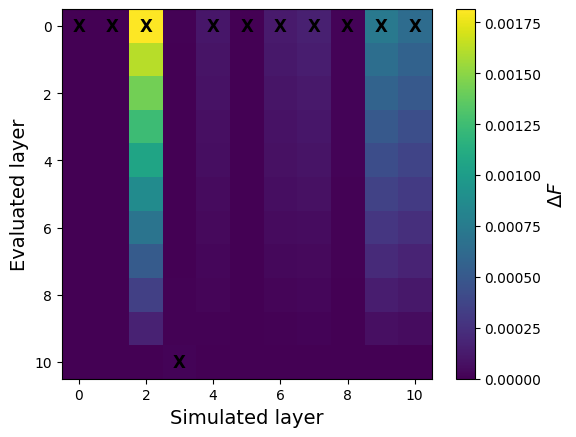

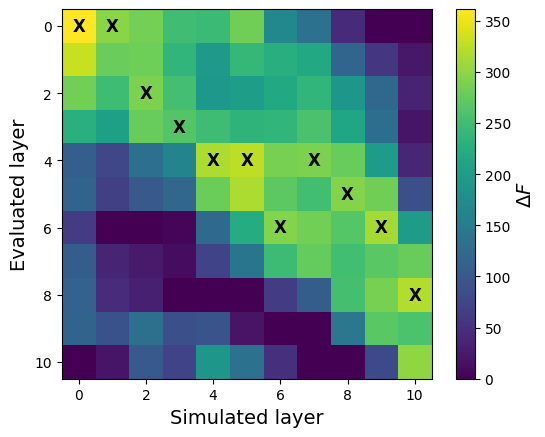

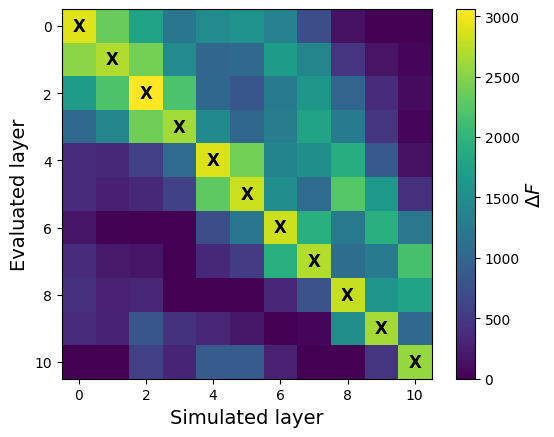

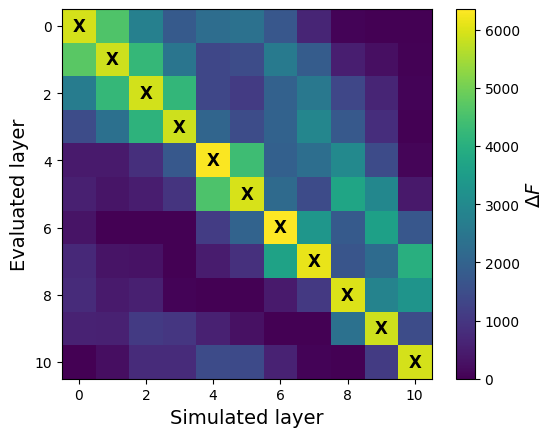

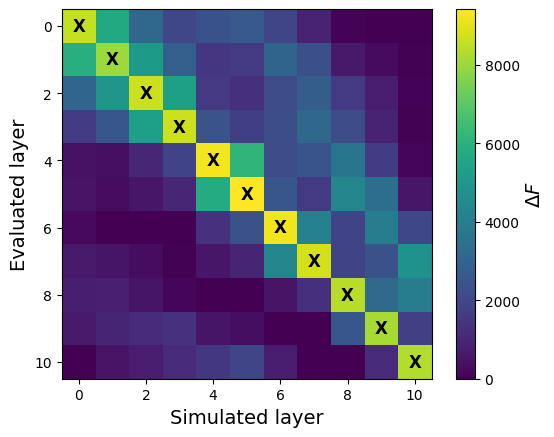

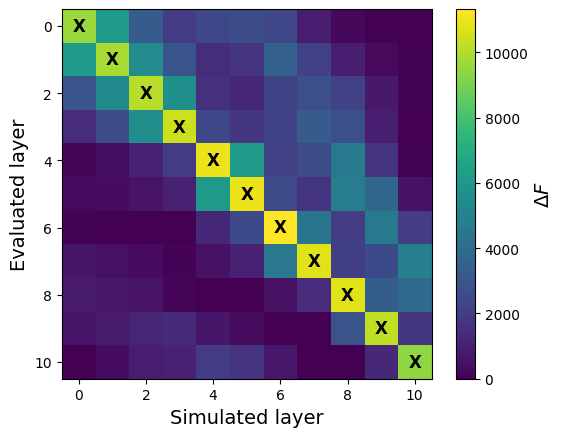

In [16]:
for snr_idx, snr in enumerate(snr_levels):
    all_layerF=snr_layerF[snr_idx,:,:]
    # Normalization step
    norm_layerF = np.zeros(all_layerF.shape)
    for l in range(n_layers):
        norm_layerF[l,:] = all_layerF[l,:] - np.min(all_layerF[l,:])

    plt.figure()
    # Transpose for visualization
    im=plt.imshow(norm_layerF.T)

    # Find the indices of the max value in each column
    max_indices = np.argmax(norm_layerF, axis=1)

    # Plot an 'X' at the center of the square for each column's maximum
    for idx, max_idx in enumerate(max_indices):
        plt.text(idx, max_idx, 'X', fontsize=12, ha='center', va='center', color='black', weight='bold')

    plt.xlabel('Simulated layer', fontsize=14)
    plt.ylabel('Evaluated layer', fontsize=14)
    cb=plt.colorbar(im)
    cb.set_label(r'$\Delta F$', fontsize=14)

In [3]:
def diagonal_off_diagonal_ratio(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("The input matrix must be square.")
    
    # Extract diagonal elements
    diagonal_elements = np.diag(matrix)
    
    # Compute the 2-norm of diagonal elements
    diagonal_norm = np.linalg.norm(diagonal_elements)
    
    # Compute the Frobenius norm of the entire matrix
    total_norm = np.linalg.norm(matrix, ord='fro')
    
    # Calculate the norm of off-diagonal elements
    off_diagonal_norm = np.sqrt(total_norm**2 - diagonal_norm**2)
    
    # Calculate the ratio
    ratio = diagonal_norm / off_diagonal_norm if off_diagonal_norm != 0 else np.inf
    
    return ratio

def fraction_not_skew_symmetric(A):
    # Compute the skew-symmetric part of A
    skew_symmetric_part = (A - A.T) / 2
    
    # Compute the Frobenius norm of the original matrix
    frobenius_norm_A = np.linalg.norm(A, 'fro')
    
    # Compute the Frobenius norm of the skew-symmetric part
    frobenius_norm_skew = np.linalg.norm(skew_symmetric_part, 'fro')
    
    # Calculate the fraction of the total energy that is not skew-symmetric
    fraction_not_skew = 1 - (frobenius_norm_skew / (np.sqrt(2) * frobenius_norm_A))**2
    
    return fraction_not_skew

def correlation_coefficient(matrix):
    d = matrix.shape[0]
    j = np.ones(d)
    r = np.arange(1, d + 1)

    # Compute the sum of all entries in the matrix
    n = np.sum(matrix)

    # Compute ?x, ?y, ?x^2, ?y^2, and ?xy using matrix A and vectors r and j
    sum_x = np.dot(r, np.dot(matrix, j))
    sum_y = np.dot(j, np.dot(matrix, r))
    sum_x2 = np.dot(r**2, np.dot(matrix, j))
    sum_y2 = np.dot(j, np.dot(matrix, r**2))
    sum_xy = np.dot(r, np.dot(matrix, r))

    # Compute the numerator and denominator for the correlation coefficient
    numerator = n * sum_xy - sum_x * sum_y
    denominator = np.sqrt(n * sum_x2 - sum_x**2) * np.sqrt(n * sum_y2 - sum_y**2)

    # Calculate the correlation coefficient
    correlation = numerator / denominator

    return correlation

def triangular_dominance(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("The input matrix must be square.")
    
    n = matrix.shape[0]
    
    # Extract the upper and lower triangular parts, excluding the diagonal
    upper_triangular = np.triu(matrix, k=1)
    lower_triangular = np.tril(matrix, k=-1)
    
    # Sum the upper and lower triangular parts
    upper_sum = np.sum(upper_triangular)
    lower_sum = np.sum(lower_triangular)
    
    # Calculate the dominance metric
    dominance = (lower_sum-upper_sum) / (upper_sum + lower_sum)
    
    return dominance

def overall_accuracy(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("The input matrix must be square.")
    
    n = matrix.shape[0]
    correct_columns = 0
    
    # Loop through each column and check if the maximum value is on the diagonal
    for j in range(n):
        max_index = np.argmax(matrix[:, j])
        if max_index == j:
            correct_columns += 1
    
    # Calculate the percentage of correct columns
    accuracy = (correct_columns / n) * 100
    
    return accuracy

Text(0, 0.5, 'Diagonality')

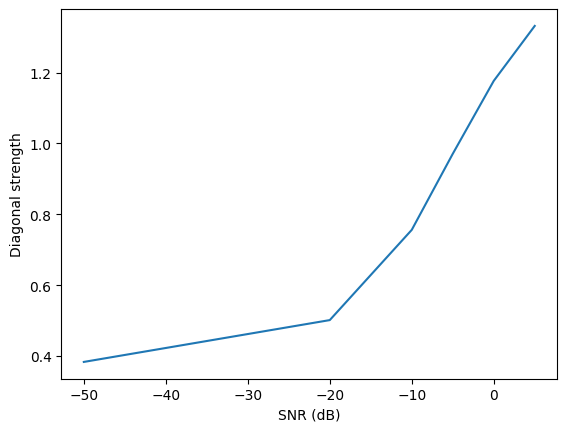

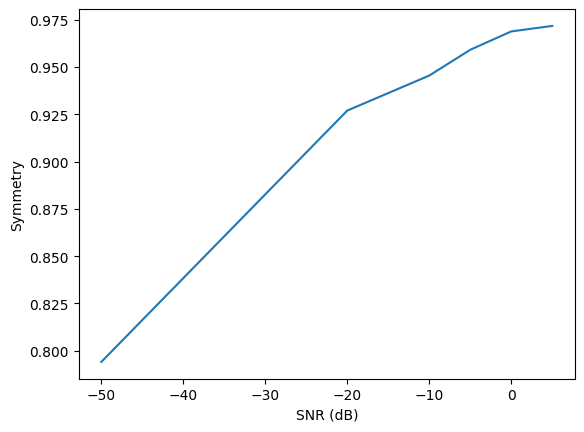

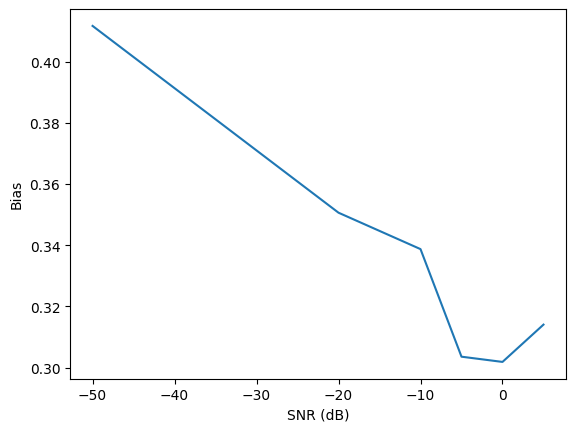

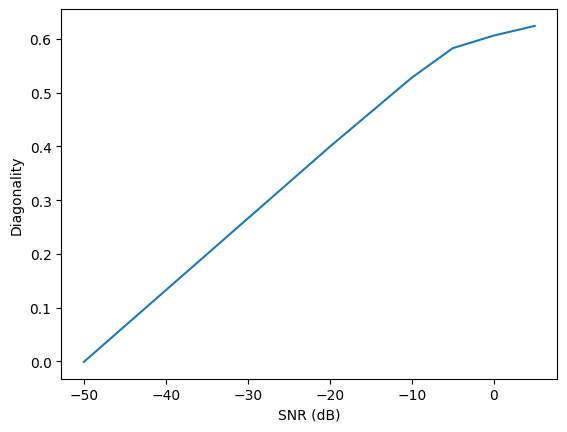

In [27]:
snr_ratios=[]
snr_fractions=[]
snr_correlations=[]
snr_biases=[]
for snr_idx, snr in enumerate(snr_levels):
    all_layerF=snr_layerF[snr_idx,:,:]
    # Normalization step
    norm_layerF = np.zeros(all_layerF.shape)
    for l in range(n_layers):
        norm_layerF[l,:] = all_layerF[l,:] - np.min(all_layerF[l,:])
        
    snr_ratios.append(diagonal_off_diagonal_ratio(norm_layerF))
    snr_fractions.append(fraction_not_skew_symmetric(norm_layerF))
    snr_correlations.append(correlation_coefficient(norm_layerF))
    snr_biases.append(triangular_dominance(norm_layerF))
    
plt.figure()
plt.plot(snr_levels, snr_ratios)
plt.xlabel('SNR (dB)')
plt.ylabel('Diagonal strength')

plt.figure()
plt.plot(snr_levels, snr_fractions)
plt.xlabel('SNR (dB)')
plt.ylabel('Symmetry')

plt.figure()
plt.plot(snr_levels, snr_biases)
plt.xlabel('SNR (dB)')
plt.ylabel('Bias')

plt.figure()
plt.plot(snr_levels, snr_correlations)
plt.xlabel('SNR (dB)')
plt.ylabel('Diagonality')

In [4]:
out_dir='../output/snr_simulations'
n_layers=11


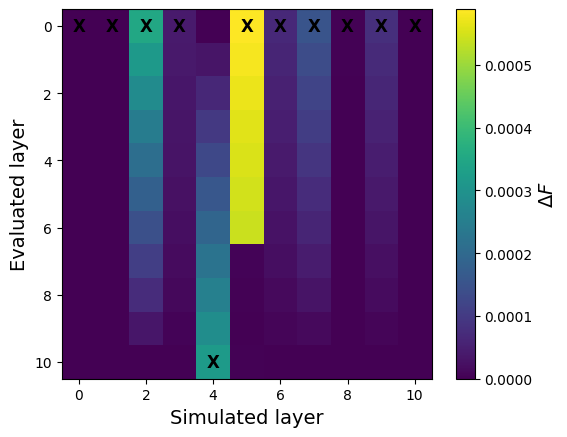

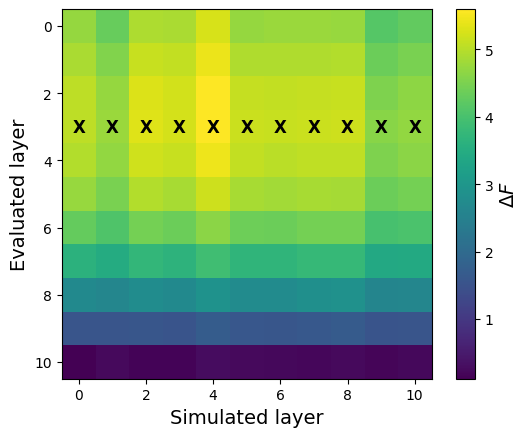

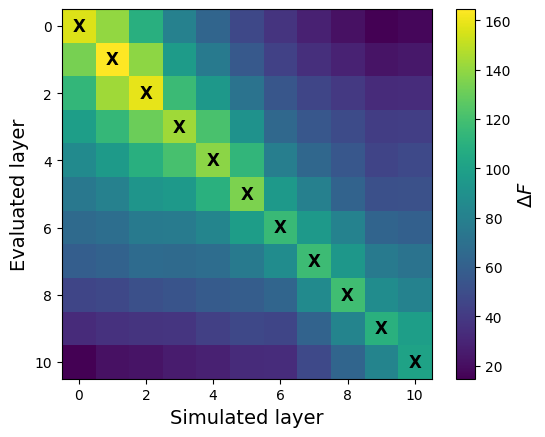

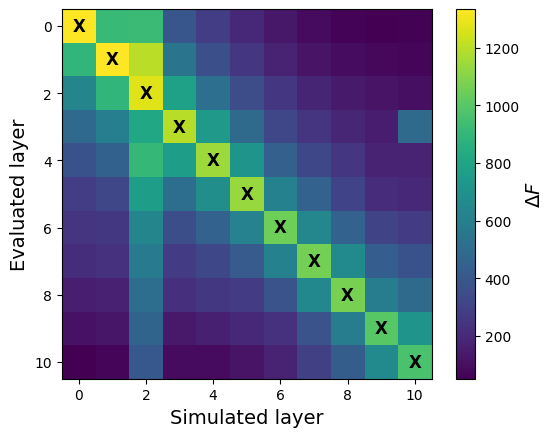

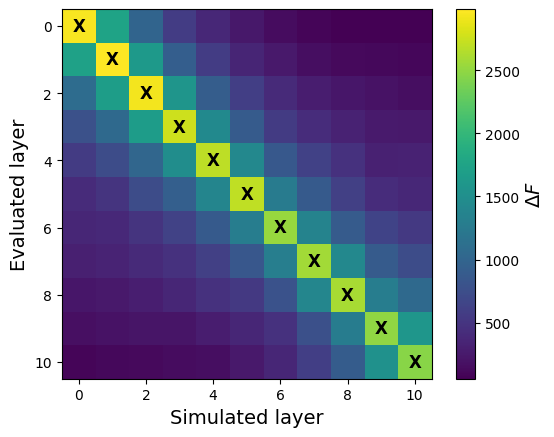

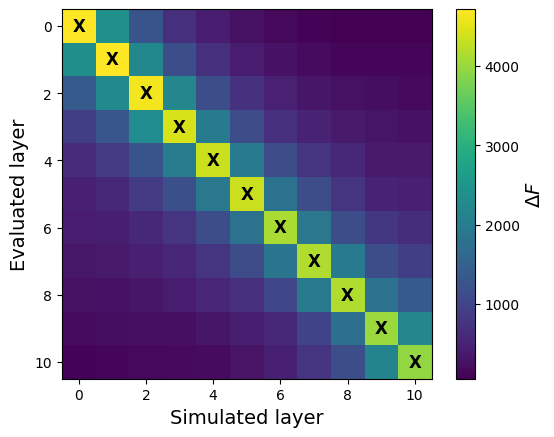

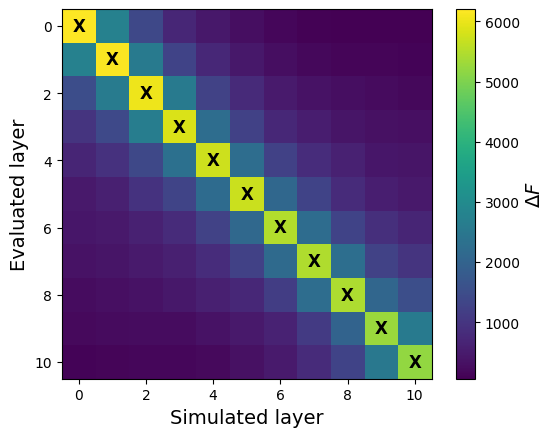

In [9]:
n_sims=50
diagonality=np.zeros((len(snr_levels),n_sims))
diag_strength=np.zeros((len(snr_levels),n_sims))
bias=np.zeros((len(snr_levels),n_sims))
accuracy=np.zeros((len(snr_levels),n_sims))


n_iter=100
diagonality_shuf=np.zeros((len(snr_levels),n_sims,n_iter))
diag_strength_shuf=np.zeros((len(snr_levels),n_sims,n_iter))
bias_shuf=np.zeros((len(snr_levels),n_sims,n_iter))
accuracy_shuf=np.zeros((len(snr_levels),n_sims,n_iter))


for snr_idx, snr in enumerate(snr_levels):
    fnames=sorted(glob.glob(os.path.join(out_dir, f'*snr_{snr}.pickle')))
    m_norm_layerF=[]
    for f_idx, fname in enumerate(fnames):
        with open(fname,'rb') as file:
            results=pickle.load(file)
        all_layerF=results['all_layerF']
        # Normalization step
        norm_layerF = np.zeros(all_layerF.shape)
        for l in range(n_layers):
            norm_layerF[l,:] = all_layerF[l,:] - np.min(all_layerF[l,:])
            
        diagonality[snr_idx, f_idx] = correlation_coefficient(norm_layerF)
        diag_strength[snr_idx, f_idx] = diagonal_off_diagonal_ratio(norm_layerF)
        bias[snr_idx, f_idx] = triangular_dominance(norm_layerF)
        accuracy[snr_idx, f_idx] = overall_accuracy(norm_layerF)
        m_norm_layerF.append(norm_layerF)
        
        for s_idx in range(n_iter):
            shuff_layerF=norm_layerF[np.random.permutation(np.arange(n_layers)),:]
            shuff_layerF=shuff_layerF[:,np.random.permutation(np.arange(n_layers))]
            diagonality_shuf[snr_idx, f_idx, s_idx] = correlation_coefficient(shuff_layerF)
            diag_strength_shuf[snr_idx, f_idx, s_idx] = diagonal_off_diagonal_ratio(shuff_layerF)
            bias_shuf[snr_idx, f_idx, s_idx] = triangular_dominance(shuff_layerF)
            accuracy_shuf[snr_idx, f_idx, s_idx] = overall_accuracy(shuff_layerF)
            
    m_norm_layerF=np.mean(np.array(m_norm_layerF),axis=0)
    
    plt.figure()
    # Transpose for visualization
    im=plt.imshow(m_norm_layerF.T)

    # Find the indices of the max value in each column
    max_indices = np.argmax(m_norm_layerF, axis=1)

    # Plot an 'X' at the center of the square for each column's maximum
    for idx, max_idx in enumerate(max_indices):
        plt.text(idx, max_idx, 'X', fontsize=12, ha='center', va='center', color='black', weight='bold')

    plt.xlabel('Simulated layer', fontsize=14)
    plt.ylabel('Evaluated layer', fontsize=14)
    cb=plt.colorbar(im)
    cb.set_label(r'$\Delta F$', fontsize=14)

In [10]:
lci_diagonality=np.percentile(diagonality_shuf.reshape(len(snr_levels),-1), 5, axis=-1)
mci_diagonality=np.percentile(diagonality_shuf.reshape(len(snr_levels),-1), 50, axis=-1)
uci_diagonality=np.percentile(diagonality_shuf.reshape(len(snr_levels),-1), 95, axis=-1)

lci_diag_strength=np.percentile(diag_strength_shuf.reshape(len(snr_levels),-1), 5, axis=-1)
mci_diag_strength=np.percentile(diag_strength_shuf.reshape(len(snr_levels),-1), 50, axis=-1)
uci_diag_strength=np.percentile(diag_strength_shuf.reshape(len(snr_levels),-1), 95, axis=-1)

lci_bias=np.percentile(bias_shuf.reshape(len(snr_levels),-1), 5, axis=-1)
mci_bias=np.percentile(bias_shuf.reshape(len(snr_levels),-1), 50, axis=-1)
uci_bias=np.percentile(bias_shuf.reshape(len(snr_levels),-1), 95, axis=-1)

lci_accuracy=np.percentile(accuracy_shuf.reshape(len(snr_levels),-1), 5, axis=-1)
mci_accuracy=np.percentile(accuracy_shuf.reshape(len(snr_levels),-1), 50, axis=-1)
uci_accuracy=np.percentile(accuracy_shuf.reshape(len(snr_levels),-1), 95, axis=-1)

Text(0, 0.5, 'Accuracy')

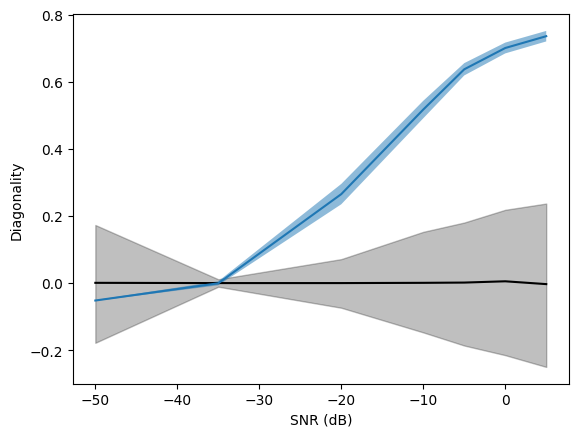

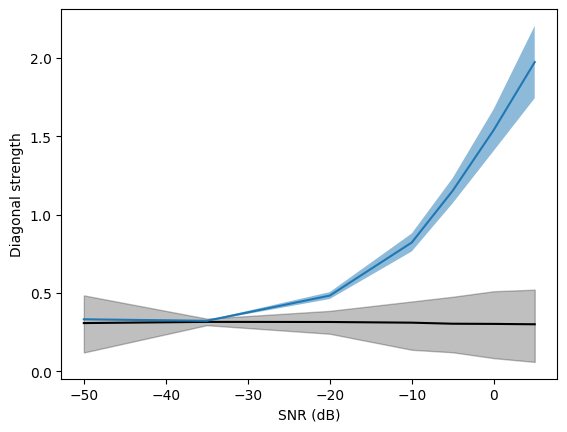

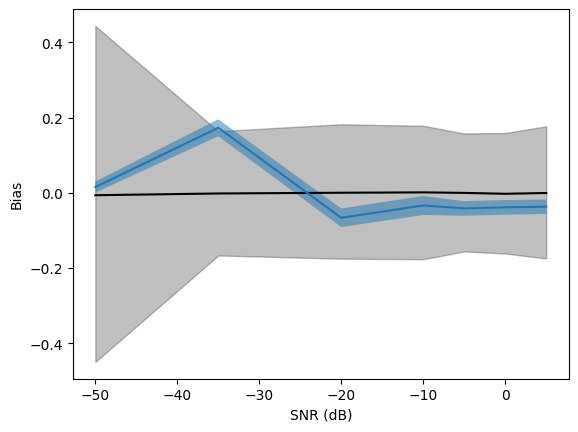

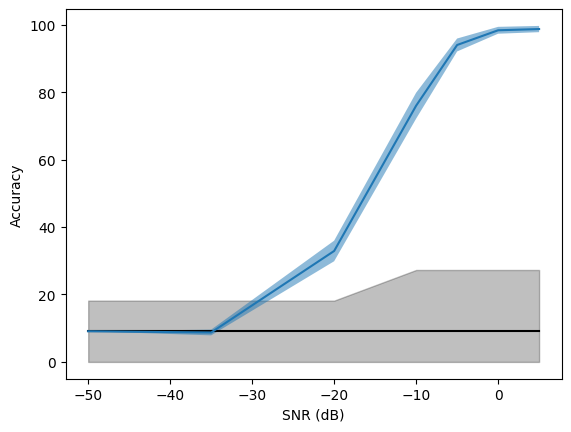

In [11]:
m_diagonality = np.mean(diagonality, axis=-1)
se_diagonality = np.std(diagonality, axis=-1)/np.sqrt(n_sims)
plt.figure()
plt.plot(snr_levels, mci_diagonality, color='k')
plt.fill_between(snr_levels, lci_diagonality, uci_diagonality, alpha=0.25, color='k')
plt.plot(snr_levels, m_diagonality)
plt.fill_between(snr_levels, m_diagonality-se_diagonality, m_diagonality+se_diagonality,alpha=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('Diagonality')

m_diag_strength = np.mean(diag_strength, axis=-1)
se_diag_strength = np.std(diag_strength, axis=-1)/np.sqrt(n_sims)
plt.figure()
plt.plot(snr_levels, mci_diag_strength, color='k')
plt.fill_between(snr_levels, lci_diag_strength, uci_diag_strength, alpha=0.25, color='k')
plt.plot(snr_levels, m_diag_strength)
plt.fill_between(snr_levels, m_diag_strength-se_diag_strength, m_diag_strength+se_diag_strength,alpha=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('Diagonal strength')

m_bias = np.mean(bias, axis=-1)
se_bias = np.std(bias, axis=-1)/np.sqrt(n_sims)
plt.figure()
plt.plot(snr_levels, mci_bias, color='k')
plt.fill_between(snr_levels, lci_bias, uci_bias, alpha=0.25, color='k')
plt.plot(snr_levels, m_bias)
plt.fill_between(snr_levels, m_bias-se_bias, m_bias+se_bias,alpha=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('Bias')

m_accuracy = np.mean(accuracy, axis=-1)
se_accuracy = np.std(accuracy, axis=-1)/np.sqrt(n_sims)
plt.figure()
plt.plot(snr_levels, mci_accuracy, color='k')
plt.fill_between(snr_levels, lci_accuracy, uci_accuracy, alpha=0.25, color='k')
plt.plot(snr_levels, m_accuracy)
plt.fill_between(snr_levels, m_accuracy-se_accuracy, m_accuracy+se_accuracy,alpha=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy')

/home/bonaiuto/miniconda3/envs/laminar_baby/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


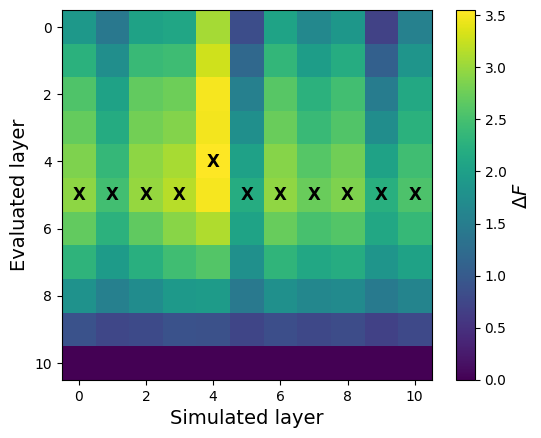

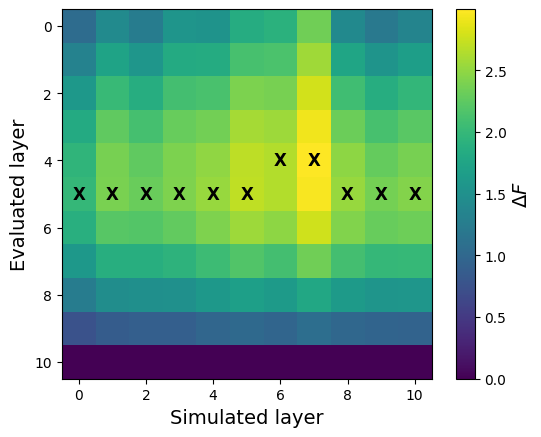

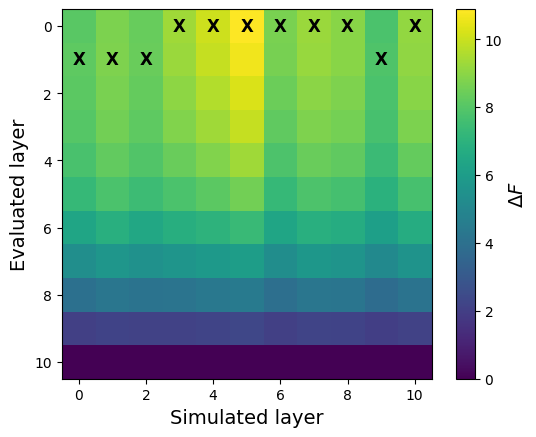

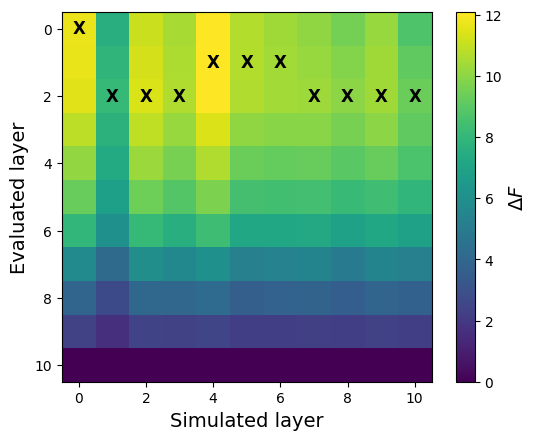

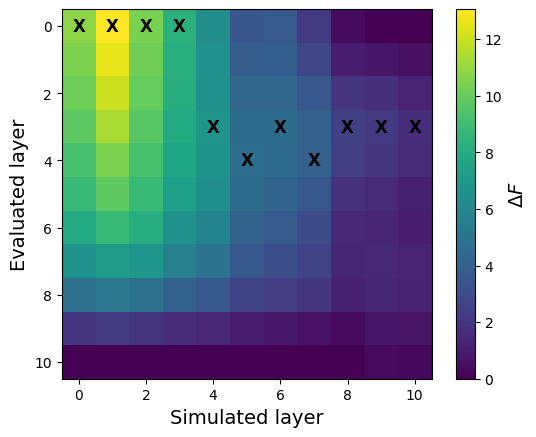

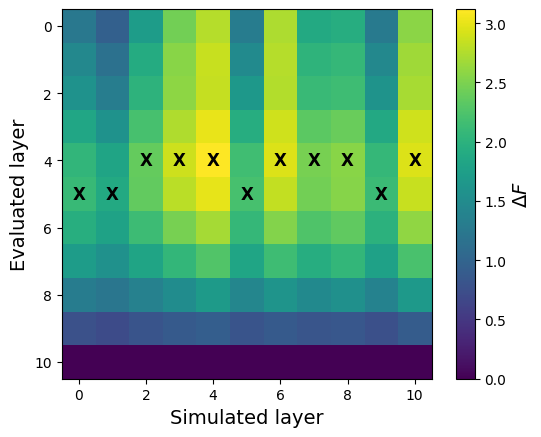

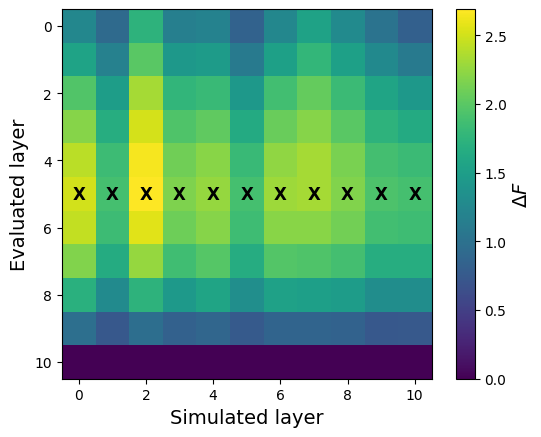

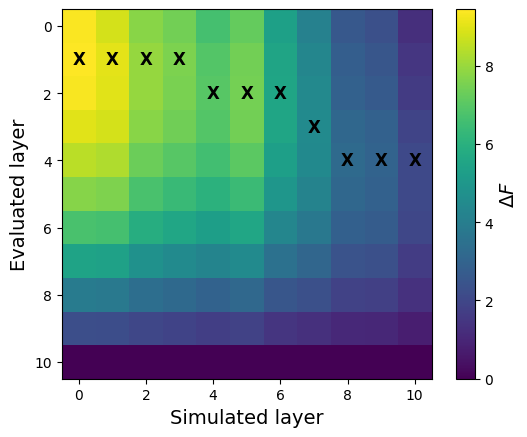

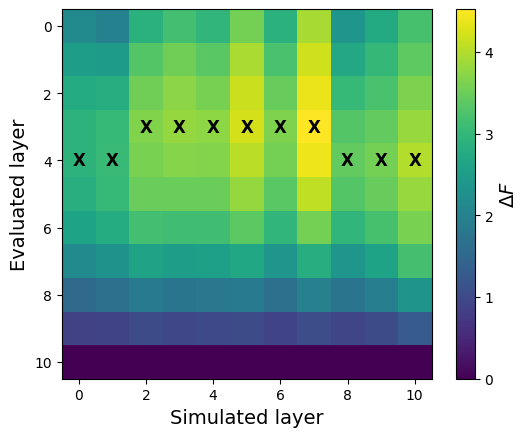

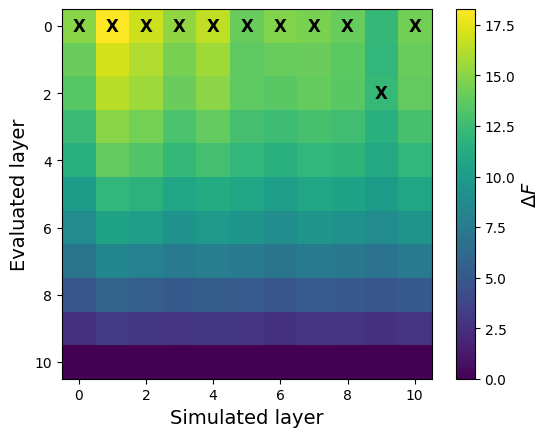

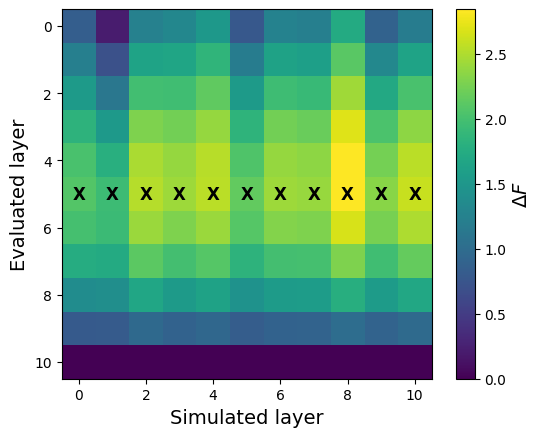

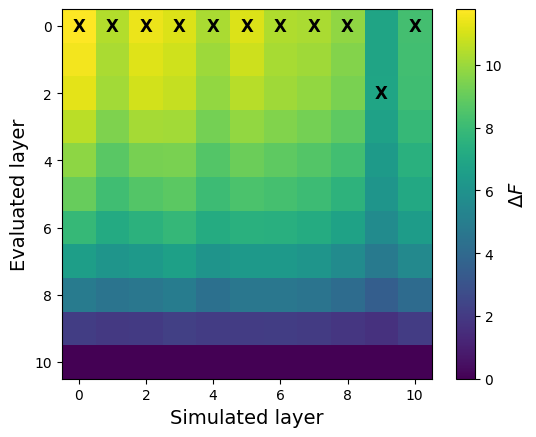

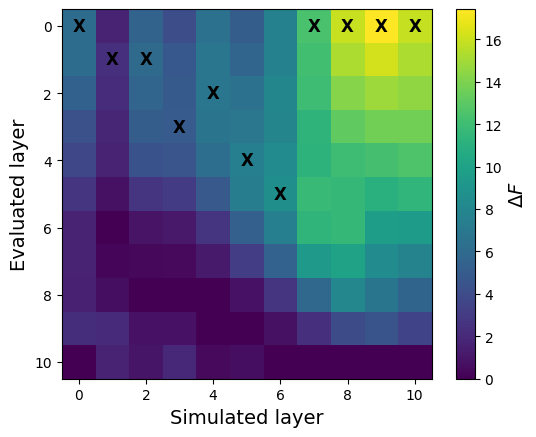

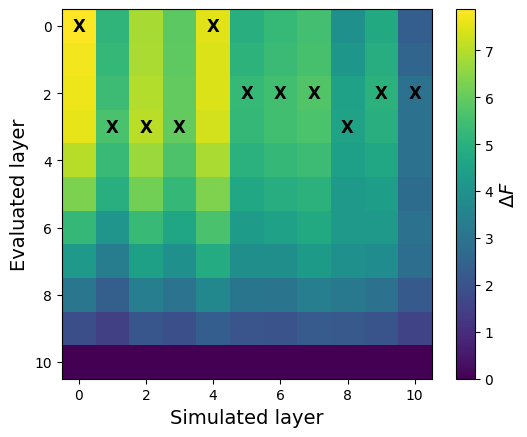

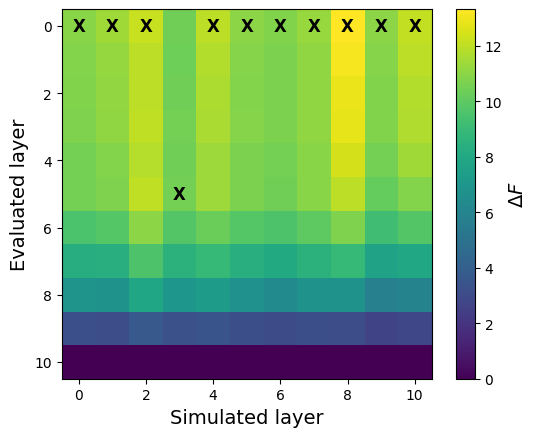

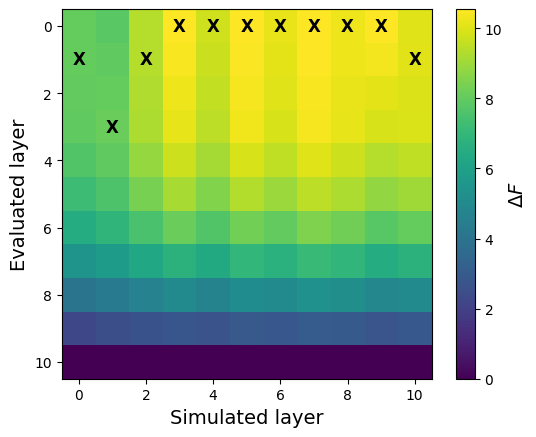

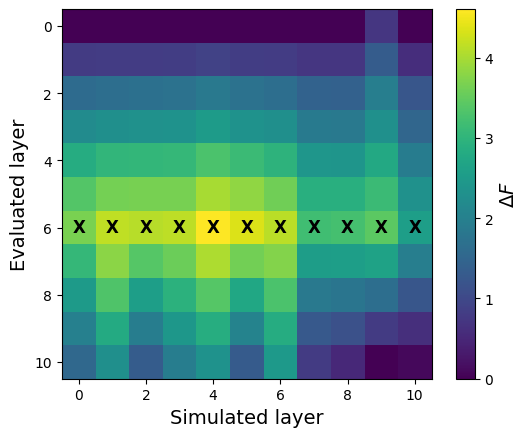

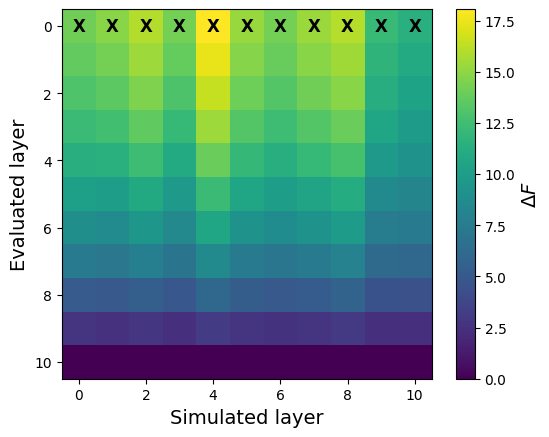

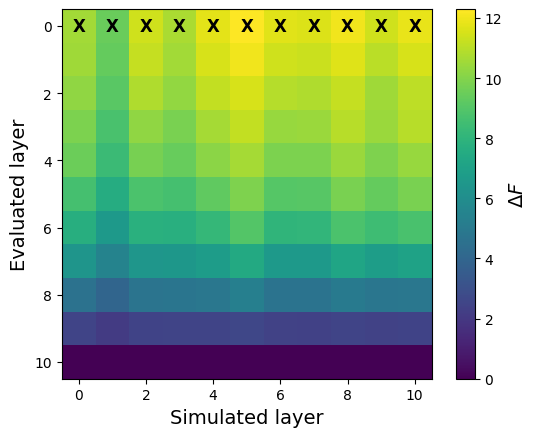

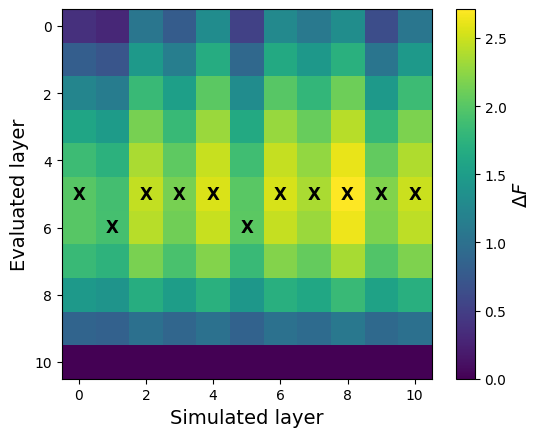

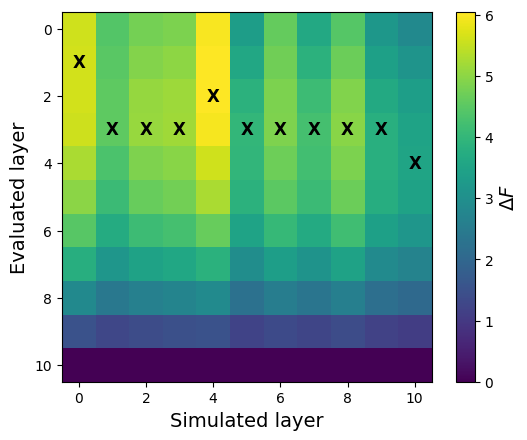

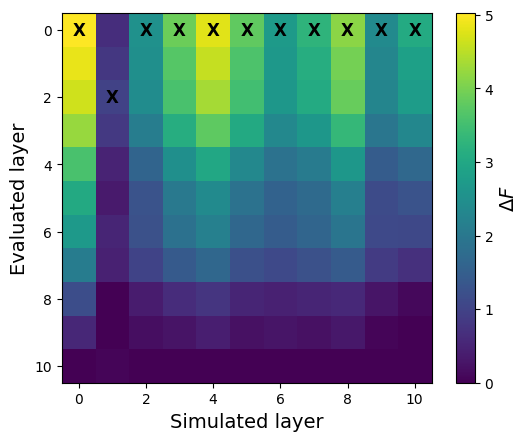

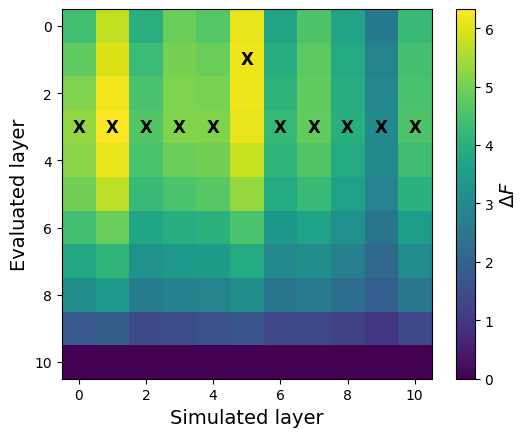

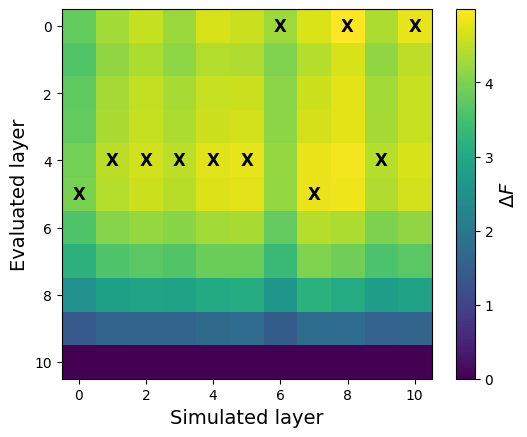

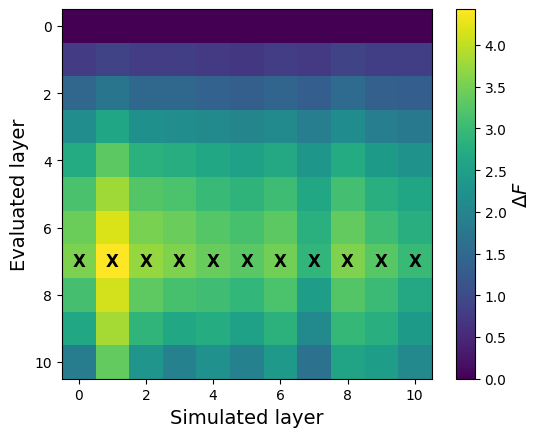

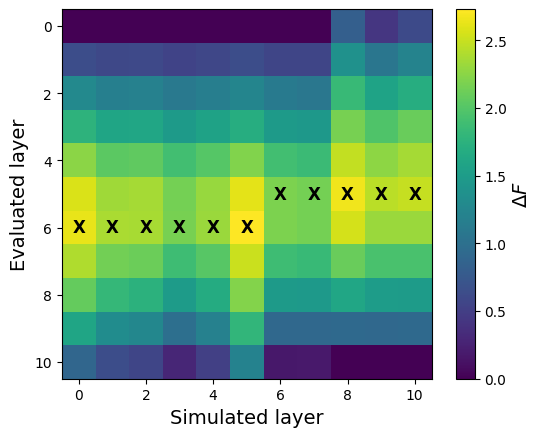

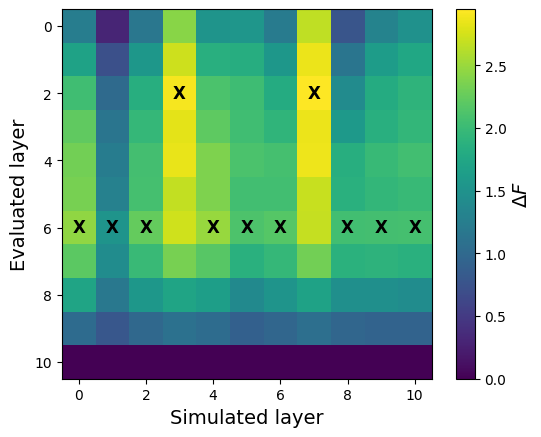

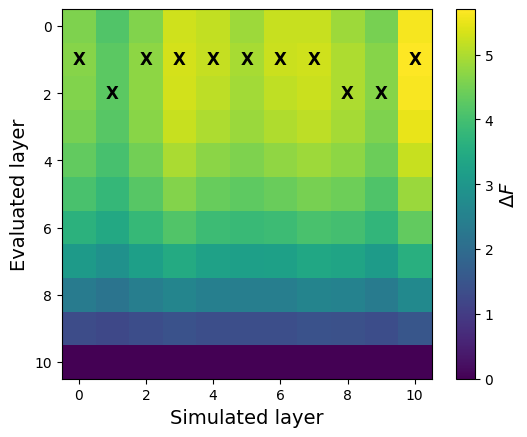

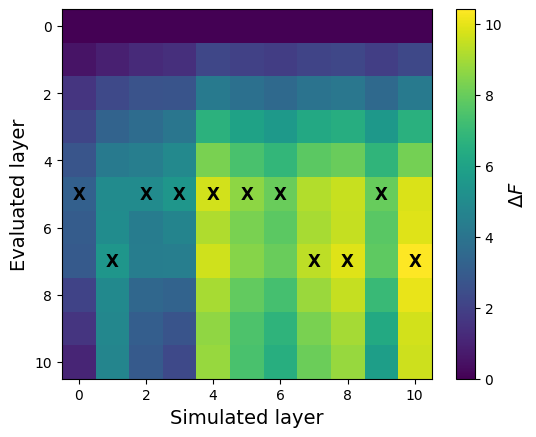

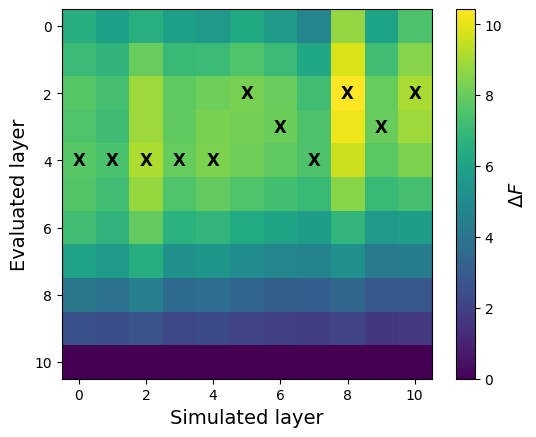

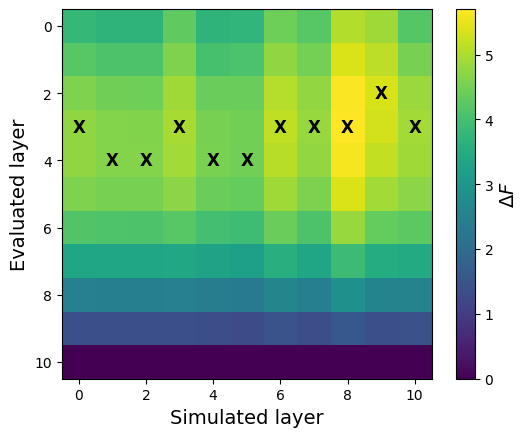

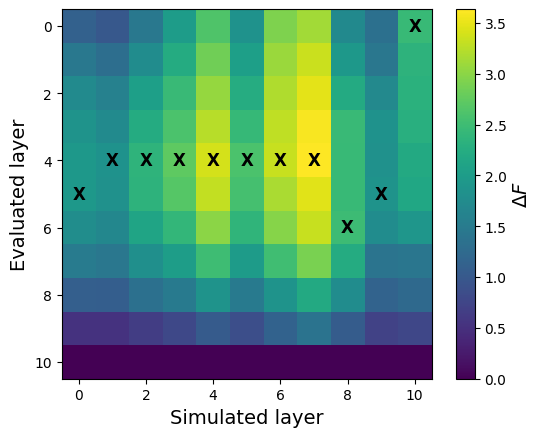

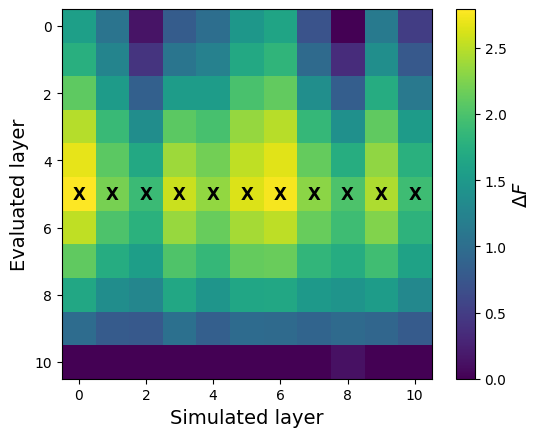

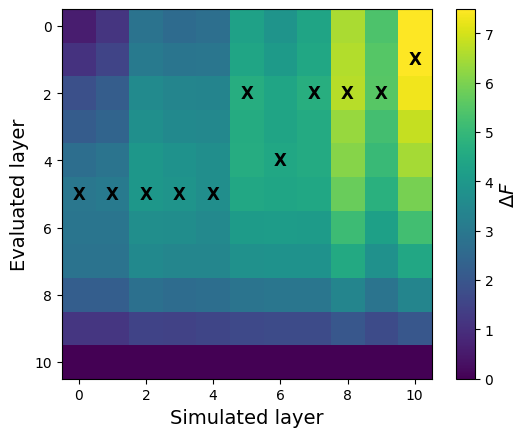

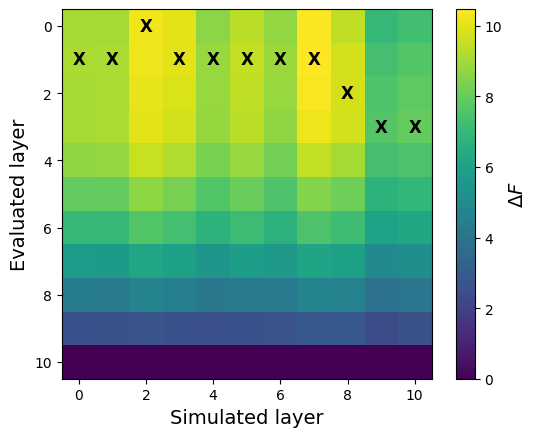

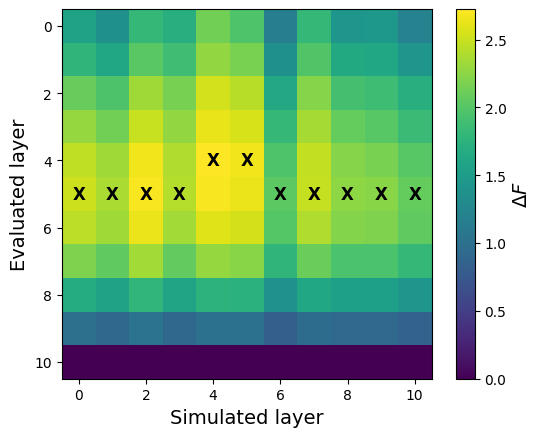

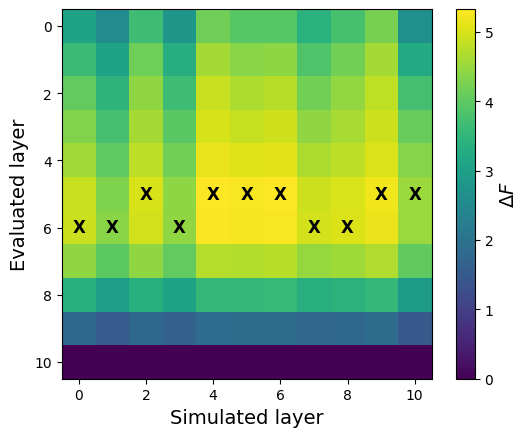

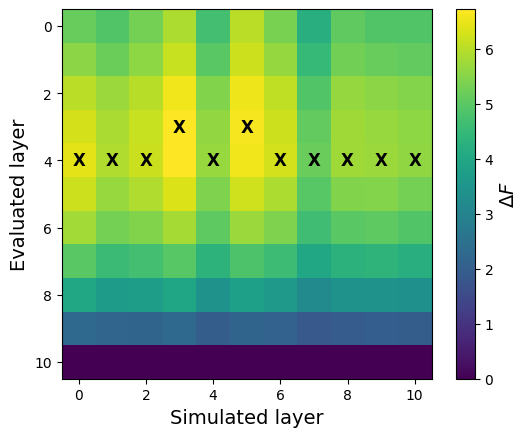

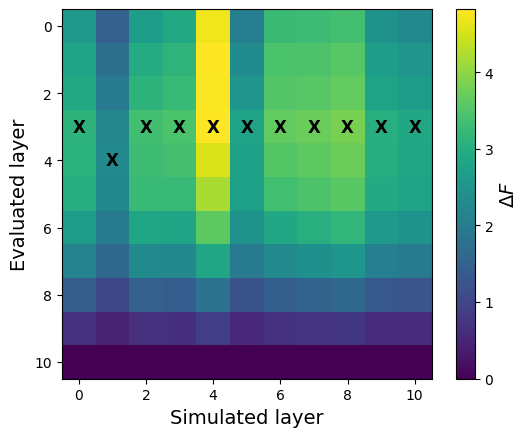

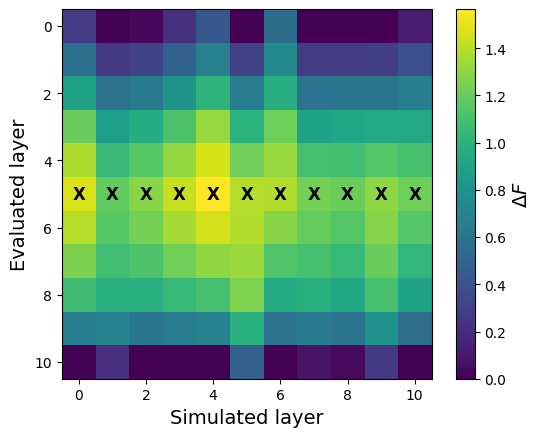

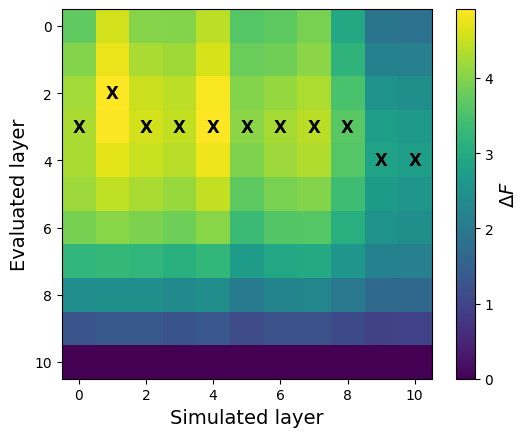

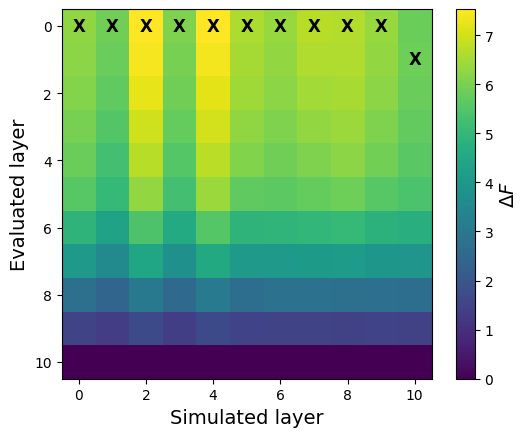

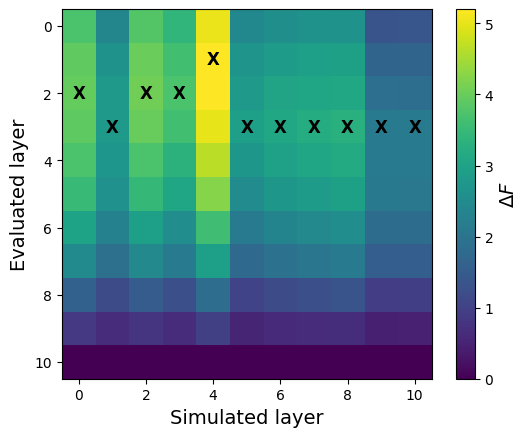

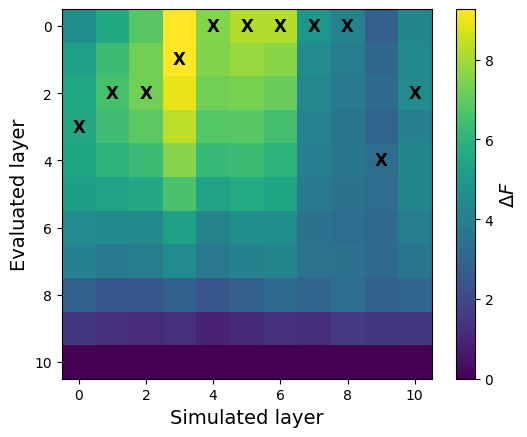

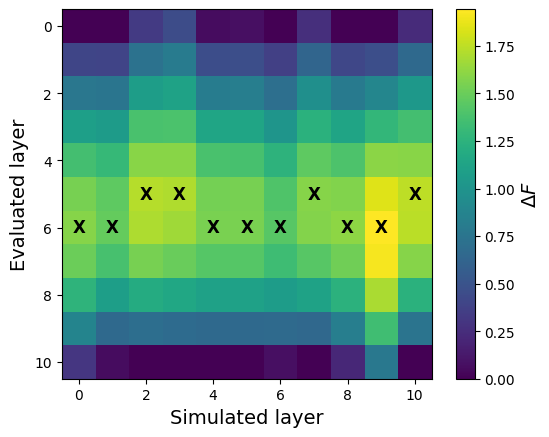

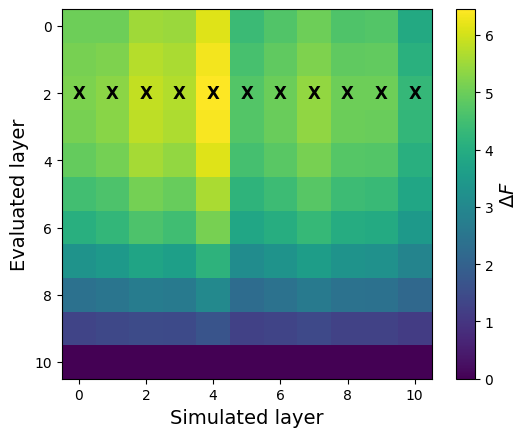

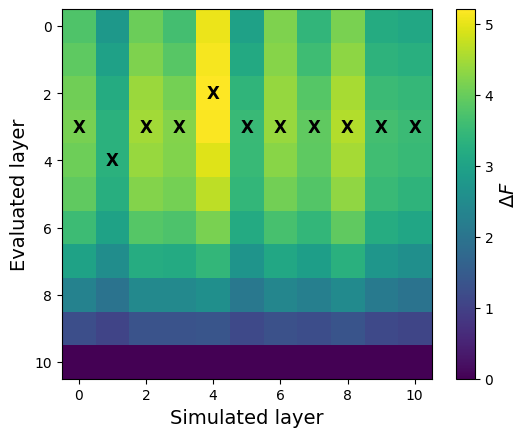

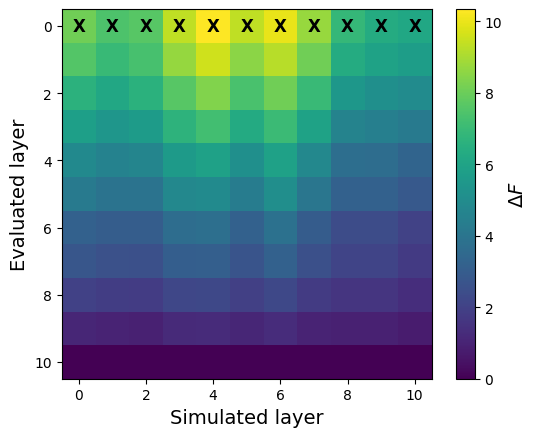

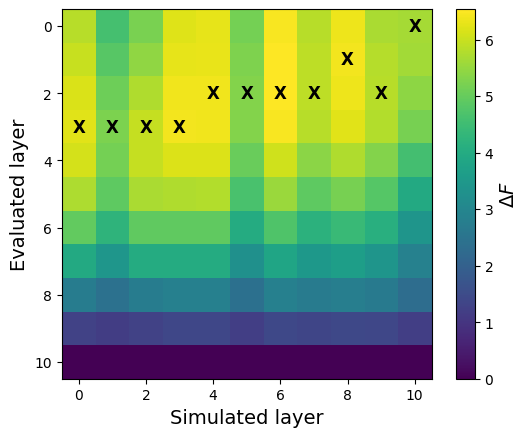

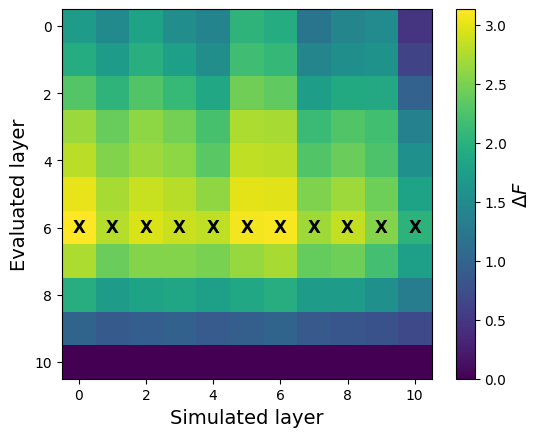

In [12]:
snr=-35
fnames=sorted(glob.glob(os.path.join(out_dir, f'*snr_{snr}.pickle')))
m_norm_layerF=[]
for f_idx, fname in enumerate(fnames):
    with open(fname,'rb') as file:
        results=pickle.load(file)
    all_layerF=results['all_layerF']
    # Normalization step
    norm_layerF = np.zeros(all_layerF.shape)
    for l in range(n_layers):
        norm_layerF[l,:] = all_layerF[l,:] - np.min(all_layerF[l,:])

    plt.figure()
    # Transpose for visualization
    im=plt.imshow(norm_layerF.T)

    # Find the indices of the max value in each column
    max_indices = np.argmax(norm_layerF, axis=1)

    # Plot an 'X' at the center of the square for each column's maximum
    for idx, max_idx in enumerate(max_indices):
        plt.text(idx, max_idx, 'X', fontsize=12, ha='center', va='center', color='black', weight='bold')

    plt.xlabel('Simulated layer', fontsize=14)
    plt.ylabel('Evaluated layer', fontsize=14)
    cb=plt.colorbar(im)
    cb.set_label(r'$\Delta F$', fontsize=14)